In [46]:
cd /home/dsi/mbouchouia/code/git/PRIM/Notebooks/

/home/dsi/mbouchouia/code/git/PRIM/Notebooks


In [2]:
import sklearn
import itertools

In [3]:
from sklearn.metrics import r2_score

In [4]:
from importlib import reload

In [5]:
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib

In [6]:
import time
import sys
import pymongo
import os
sys.path.append('../scripts/')
sys.path.append('../papers code/DCRNN/')
import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import pandas as pd
from tf_cuda_subprocess import *
from   functools import reduce
import seaborn as sns
import models
from mongoConnection import *
sns.set()
results_path = "../images/model results/"
def saveFig():
    if not os.path.isdir(results_path+model_name):
        os.makedirs(results_path+model_name)
    print(results_path+model_name)
    plt.savefig(results_path+model_name+input(),dpi=300,bbox_inches='tight')

In [7]:
import tensorflow as tf

# @RunAsCUDASubprocess(num_gpus=1)
def createSession():
    config = tf.ConfigProto(intra_op_parallelism_threads=8, 
                            inter_op_parallelism_threads=8,
                            allow_soft_placement=True,
                            log_device_placement=True
                           )

    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    session = tf.Session(config=config,graph=tf.get_default_graph())

    tf.keras.backend.set_session(session)
createSession()

In [8]:
from model import dcrnn_cell

In [9]:
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")
counts = pd.read_pickle('../data/monthsCount__0.pckl')

speeds_05 = pd.read_pickle("../data/monthsSpeed__5.pckl")
counts_05 = pd.read_pickle('../data/monthsCount__5.pckl')

speeds_10 = pd.read_pickle("../data/monthsSpeed__10.pckl")
counts_10 = pd.read_pickle('../data/monthsCount__10.pckl')

In [10]:
# mergeResults,segmentsMeta, mergedSegments= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=np.array([2,1,1,1]),speedsMx=speeds)
# mergeResults.to_pickle("../data/mergeResults.pckl")
# segmentsMeta.to_pickle("../data/segmentsMeta.pckl")
# mergedSegments.to_pickle("../data/mergedSegments.pckl")

In [11]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
mergedSegments=pd.read_pickle("../data/mergedSegments.pckl")

In [12]:
data_cleaner = models.DataCleaner(speeds,segmentsMeta,mergeResults,counts,0.80)


data_cleaner_05 = models.DataCleaner(speeds_05,segmentsMeta,mergeResults,counts_05,0.80)


data_cleaner_10 = models.DataCleaner(speeds_10,segmentsMeta,mergeResults,counts_10,0.80)

intersectIndexes= np.intersect1d(np.intersect1d(data_cleaner.data.index,data_cleaner_05.data.index),data_cleaner_10.data.index)

In [13]:
mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)
speedssegs = speeds
speedssegs = speedssegs.assign(newIndex =mergedIndex.reindex(speedssegs.index).values)
speedssegs = speedssegs[~speedssegs.newIndex.isna()]

naStats=speedssegs.groupby('newIndex').apply(lambda x : pd.Series([(x.isna().sum(axis=1)/x.columns.size).mean(),(x.isna().sum(axis=1)/x.columns.size).min(),len(x)],index=["mean","min","nSeg"])).reindex(intersectIndexes)

intersectIndexes= np.setdiff1d(np.intersect1d(np.intersect1d(data_cleaner.data.index,data_cleaner_05.data.index),data_cleaner_10.data.index),naStats[naStats['min']>0.4].index)

In [14]:
speedDF = data_cleaner.data.reindex(intersectIndexes)
data_cleaner.data=data_cleaner.data.reindex(intersectIndexes)
countDF = data_cleaner.counts.reindex(intersectIndexes)
data_cleaner.counts = data_cleaner.counts.reindex(intersectIndexes)

speedDF_05 = data_cleaner_05.data.reindex(intersectIndexes)
countDF_05 = data_cleaner_05.counts.reindex(intersectIndexes)
speedDF_10 = data_cleaner_10.data.reindex(intersectIndexes)
countDF_10 = data_cleaner_10.counts.reindex(intersectIndexes)


In [152]:
adjacency_matrix= OsmProcessing.getAdjacencyMatrix(segmentsMeta)

adjacency_matrix = OsmProcessing.addLevel(adjacency_matrix,3)
adjacency_matrix = OsmProcessing.mergeAdjacencyMatrix(adjacency_matrix, mergeResults, segmentsMeta)
adjacency_matrix = adjacency_matrix[speedDF.index].loc[speedDF.index]

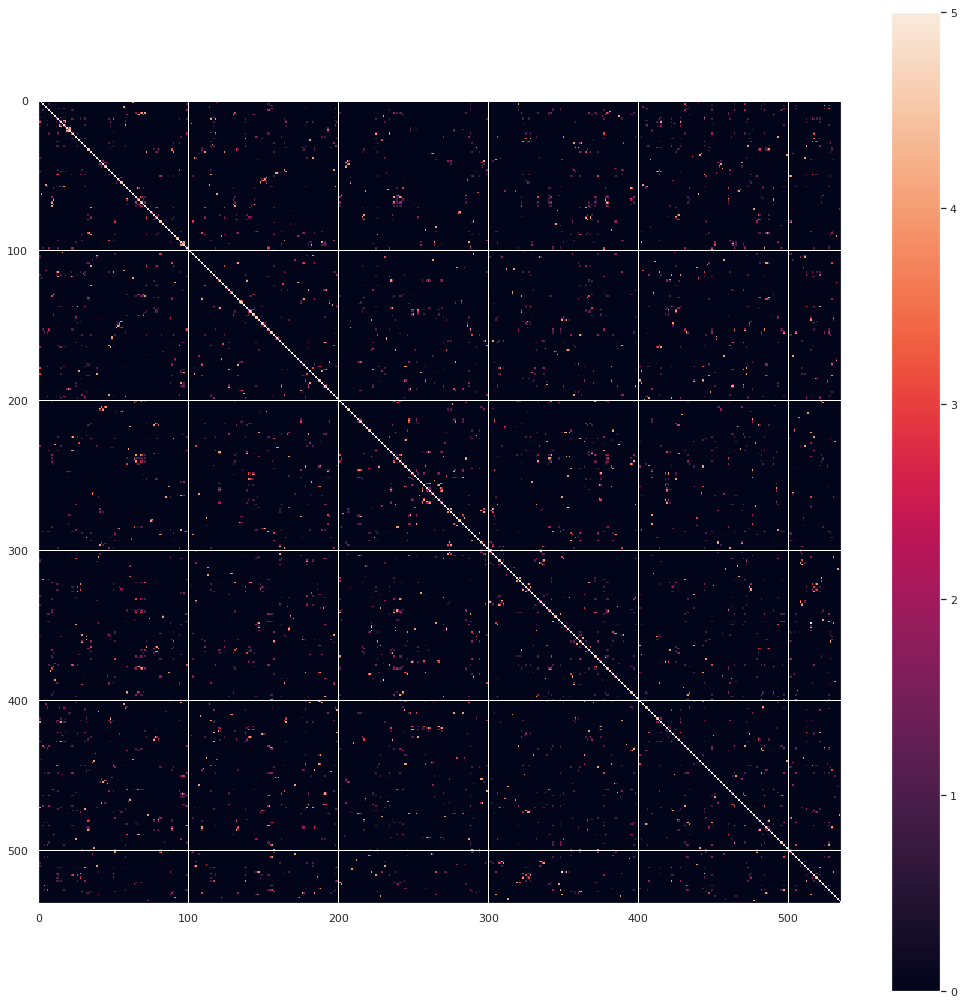

In [153]:
plt.figure(figsize=(18,18))
plt.imshow(adjacency_matrix.clip())
plt.colorbar()

In [ ]:
adjacency_matrix = adjacency_matrix.clip(upper = 1)

In [15]:
def createMlpModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):

    model = tf.keras.models.Sequential()
    #layers
    model.add(tf.keras.layers.Flatten())
    
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.Dense(neuronsPerLayer*(i+1)))
    model.add(tf.keras.layers.Dense(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

def createStackedLstmModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):
    model = tf.keras.models.Sequential()
    #layers
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.LSTM(neuronsPerLayer*(i+1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [16]:
build_grid= { 'optimizer':['Adam'],
              'nlayers':[0,1,3],
              'neuronsPerLayer':[64],
              'loss':['MSE','MAE'],
              'relu_output':[False]
             }

train_grid={
    "batch_size": [8,32,64], 
    "epochs": [100],
    "validation_split": [0.5]
}

preprocess_grid={
    
    'scale_Max':[True],
    'scale_log':[False],
    'input_lag':[1,6],
    'output_lag':[1],
    'time_as_input':[True],
    "validation_split":[0.5]
}

def getParamsFromGrid(grid):
    return [dict(list(zip(list(grid.keys()),x ))) for x in list(itertools.product(*list(grid.values())))]

def grid_search(data,buildfunc,build_grid,train_grid,preprocess_grid):

    grid = list(itertools.product( getParamsFromGrid(build_grid),
                                   getParamsFromGrid(train_grid),
                                   getParamsFromGrid(preprocess_grid)
                                 )
               )
    
    losses=[]
    val_losses=[]
    mseLoss=[]
    mseValLoss=[]
    for build_param,train_param,preprocess_param in grid :
        print(build_param,train_param,preprocess_param)
        x,y = preprocessData(data,**preprocess_param)
        xtrain = x[:int(len(x)*(train_param['validation_split']))]
        xtest = x[int(len(x)*(train_param['validation_split'])):]
        ytrain = y.reshape(-1,nSegments)[:int(len(x)*(train_param['validation_split']))]
        ytest = y.reshape(-1,nSegments)[int(len(x)*(train_param['validation_split'])):]
        tf.keras.backend.clear_session()
        tf.keras.backend.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

        model=buildfunc(**build_param)
        model.fit(xtrain,ytrain.reshape(-1,nSegments), validation_data = (xtest,ytest), **train_param,verbose=0)
        
        losses.append(model.evaluate(xtrain,ytrain,verbose=0))
        val_losses.append(model.evaluate(xtest,ytest,verbose=0))
        
        mseLoss.append(mse(reversePreProcess(ytrain,**preprocess_param),reversePreProcess(model.predict(xtrain),**preprocess_param)))
        mseValLoss.append(mse(reversePreProcess(ytest,**preprocess_param),reversePreProcess(model.predict(xtest),**preprocess_param)))
        print(losses[-1],val_losses[-1],mseLoss[-1],mseValLoss[-1])
        
    resDF = pd.DataFrame(list(zip(grid,losses,val_losses,mseLoss,mseValLoss)),columns=['params','loss_value','val_loss_value','mseLoss','mseValLoss'])
    
    return  pd.concat([resDF.params.apply(lambda x : pd.Series({**x[0],**x[1],**x[2]})),resDF[['loss_value','val_loss_value','mseLoss','mseValLoss']]],axis=1)


In [17]:
# resMlpDF = grid_search(data,createMlpModel,build_grid,train_grid,preprocess_grid)

In [18]:
# resLstmDF.groupby("time_as_input")['mseLoss'].describe()

In [19]:
# resLstmDF = grid_search(data,createStackedLstmModel,build_grid,train_grid,preprocess_grid)

In [20]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""
def multiInputMultiOutputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    lstm = tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(nSegments,name="lstm_branch")(lstm)

    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x = tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    
#     x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer,lstm_branch] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()
    

In [21]:
def monoInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(300,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(300,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )( lstm_branch)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    output_layer = tf.keras.layers.Dense( nSegments,name="Output",use_bias=False )(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [22]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(200,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(200,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    

In [23]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(250,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )(x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh  , use_bias=False)(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mae , optimizer=optimizer)   
    

In [24]:
def multiInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(100,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="slice_MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [25]:
def monoInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp = tf.keras.layers.Dense(350,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, daytime_input])
    
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh , use_bias=False)(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [26]:
def mlp():
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")

    flat = tf.keras.layers.Flatten()(main_input)
    
    dense=tf.keras.layers.Dense(nSegments,activation='sigmoid')(flat)

    # densePReLU = tf.keras.layers.PReLU(alpha_initializer="zeros")(dense)
    
    #     lstm=tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid)(lstm)

    dense = tf.keras.layers.Dropout(0.7)(dense)
    dense=tf.keras.layers.Dense(nSegments,activation='sigmoid')(dense)
#     densePReLU = tf.keras.layers.PReLU(alpha_initializer="zeros")(dense)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(dense)
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()

In [27]:
def statefullLstm():
    main_input = tf.keras.layers.Input(x_train.shape[1:],batch_size=batch_size,name="speed_input")

    lstm=tf.keras.layers.LSTM(nSegments,name="speed_lstm",stateful="true")(main_input)

    lstm_branch = tf.keras.layers.Dense(nSegments,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)


    x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( lstm_branch)
    # x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)


    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [28]:

"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def multiInputModelLstm():
    """
            __________________________________________________________________________________________________
            Layer (type)                    Output Shape         Param #     Connected to                     
            ==================================================================================================
            speed_input (InputLayer)        (None, 5, 748)       0                                            
            __________________________________________________________________________________________________
            speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
            __________________________________________________________________________________________________
            day_time_input (InputLayer)     (None, 2)            0                                            
            __________________________________________________________________________________________________
            Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                             day_time_input[0][0]             
            __________________________________________________________________________________________________
            dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
            __________________________________________________________________________________________________
            Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
            ==================================================================================================
            Total params: 425,448
            Trainable params: 425,448
            Non-trainable params: 0
            __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:], name="day_time_input")

    lstm=tf.keras.layers.LSTM(nSegments, name="speed_lstm")(main_input)
    
    lstm_branch = tf.keras.layers.Dense(nSegments, activation= tf.keras.activations.relu, name="lstm_branch")(lstm)
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    
    x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.relu )( merge_layer)


    output_layer = tf.keras.layers.Dense(nSegments, name="Output")(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input, daytime_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer, metrics=['mse'])
    data_model.model.summary()


The optimization objective for Lasso is:

$(1 / (2 * n_samples)) * ||Y - XW||^2_Fro + alpha * ||W||_21$
Where:



$||W||_21 = \sum_i \sqrt{\sum_j w_{ij}^2}$

In [29]:
def B1(n_units=300):
    "[['flatten', 'dense'], [300, 300], ['flatten', 'dense'], [300, 300], ['dense', 'dense'], [300, 300]]_20"
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    speed_layer = tf.keras.layers.Flatten()(main_input)
    speed_layer = tf.keras.layers.Dense(nSegments,activation="sigmoid")(speed_layer)
    
    count_layer = tf.keras.layers.Flatten()(count_input)
    count_layer = tf.keras.layers.Dense(nSegments,activation="sigmoid")(count_layer)
    
    layer = tf.keras.layers.Concatenate(1,name="count_speed_merge")([speed_layer, count_layer,daytime_input])
    
    layer = tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)
    layer = tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(layer)
    output_layer = tf.keras.layers.PReLU(alpha_initializer="ones",alpha_regularizer=tf.keras.regularizers.l1(0.001))(output_layer)

    model =tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=smape_loss, optimizer=optimizer,metrics=["mse"])
    data_model.model =model
    mlpModel=data_model
    model.summary()

In [30]:
def dcrnnModel(n_units=300):
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input",batch_size=batch_size)
    
    layer = tf.keras.layers.RNN(dcrnn_cell.DCGRUCell(1,adjacency_matrix.values,3,nSegments,reuse=True))(main_input)
    layer = tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(layer)

    model =tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=smape_loss, optimizer=optimizer,metrics=["mse"])
    data_model.model =model
    model.summary()
    

In [31]:
def separateDepthWiseLstmPerDay(hist_layer,day_length=20):

    n_convs = hist_layer.shape[1]//day_length
    conv_layers=[]
    for i in range(n_convs) :
        conv_layers.append(tf.keras.layers.Lambda(lambda x : x[:,i*day_length:(i+1)*day_length,:],name="historical_conv_"+str(i))(hist_layer))
        conv_layers[i]= tf.keras.layers.LSTM(200, name="LSTM_"+str(i) )(conv_layers[i])
        conv_layers[i] = tf.keras.layers.Reshape((1,conv_layers[i].shape[1]))(conv_layers[i])

    conv_layer = tf.keras.layers.Concatenate(1,name="hist_lstm_layers_concat")(conv_layers)
    return conv_layer


def separateDepthWiseConvPerDay(hist_layer,day_length=20):
    hist_layer = tf.keras.layers.Reshape((hist_layer.shape[1],1,hist_layer.shape[2]))(hist_layer)

    n_convs = hist_layer.shape[1]//day_length
    conv_layers=[]
    for i in range(n_convs) :
        conv_layers.append(tf.keras.layers.Lambda(lambda x : x[:,i*day_length:(i+1)*day_length,:],name="historical_conv_"+str(i))(hist_layer))
        conv_layers[i] = tf.keras.layers.DepthwiseConv2D((day_length,1),depth_multiplier = 1,name="conv1D_"+str(i),activation="tanh")(conv_layers[i])
        conv_layers[i] = tf.keras.layers.Reshape((conv_layers[i].shape[1],conv_layers[i].shape[3]))(conv_layers[i])
    
    conv_layer = tf.keras.layers.Concatenate(1,name="conv_layers_concat")(conv_layers)
    return conv_layer

def convMultiInputModelLstm(day_length=20):
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    historical_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:,:-(data_model.input_lag%day_length),:],name="historical_speeds")(main_input)
    
    historical_speeds_layer = separateDepthWiseConvPerDay(historical_speeds_layer,day_length)
    historical_speeds_layer = tf.keras.layers.LSTM(200, name="speed_hist_lstm")(historical_speeds_layer)
    
    historical_speeds_layer = bnActivationDropout( historical_speeds_layer,200,"tanh",0)
    
    
    
    local_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:, -(data_model.input_lag%day_length):, :],name="local_speeds")(main_input)
    local_speeds_layer = tf.keras.layers.LSTM(200, name="speed_local_lstm")(local_speeds_layer)

    local_speeds_layer = bnActivationDropout(local_speeds_layer, 200, "tanh", 0)

    speed_merge = tf.keras.layers.Concatenate(1, name="speed_merge")([local_speeds_layer, historical_speeds_layer])

    
    x = bnActivationDropout(speed_merge, 200, "tanh",0.25)
    x = bnActivationDropout(x, 200, "tanh", 0)

    
    
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam(0.0012)
    
    data_model.model.compile(loss=smape_loss, optimizer=optimizer, metrics=['mse',smape_loss])

    data_model.model.summary()

    

def convMultiInputModelMLP():
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    historical_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:,:-(data_model.input_lag%20),:],name="historical_speeds")(main_input)
    
    historical_speeds_layer = separateDepthWiseConvPerDay(historical_speeds_layer)
    historical_speeds_layer =tf.keras.layers.Flatten()(historical_speeds_layer)
    historical_speeds_layer = bnActivationDropout( historical_speeds_layer,300,"tanh",0.2 )
    
    
    
    
    local_speeds_layer = tf.keras.layers.Lambda(lambda x : x[:, -(data_model.input_lag%20):, :],name="local_speeds")(main_input)
    local_speeds_layer =tf.keras.layers.Flatten()(local_speeds_layer)


    local_speeds_layer = bnActivationDropout(local_speeds_layer, 300, "tanh", 0.2)

    speed_merge = tf.keras.layers.Concatenate(1, name="speed_merge")([local_speeds_layer, historical_speeds_layer])

    
    x = bnActivationDropout(speed_merge, 300, "tanh",0.2)
    x = bnActivationDropout(x, 300, "tanh", 0)

    
    
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile(loss=smape_loss, optimizer=optimizer, metrics=['mse',smape_loss])

    data_model.model.summary()


In [32]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def bnActivationDropout(x,units,act,drp,bn=False):
    x=tf.keras.layers.Dense( units)(x)
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation(act)(x)
    x =tf.keras.layers.Dropout(drp)(x)
    return x


def simpleMonoInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    lstm=tf.keras.layers.LSTM(nSegments,name="speed_lstm")(main_input)
    
    
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output",kernel_regularizer=tf.keras.regularizers.l1(0.0001))(lstm)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile(loss=smape_loss, optimizer=optimizer,metrics=['mse',coeff_determination])

    data_model.model.summary()


In [33]:
def countInputModelLstm():
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")

    
    count_lstm=tf.keras.layers.LSTM( 100, name="count_lstm")( count_input )
    
    count_lstm=bnActivationDropout(count_lstm,100,"tanh",0.2)

    lstm=tf.keras.layers.LSTM(100, name="speed_lstm")( main_input)

    lstm=bnActivationDropout(lstm,100,"tanh",0.2)

    
    count_speed_merge = tf.keras.layers.Concatenate(1,name="count_speed_merge")([count_lstm, lstm])

    
    x = bnActivationDropout(count_speed_merge,100,"tanh",0.2)

    x = tf.keras.layers.Concatenate(1,name="time_input_concat")([daytime_input,x])

    x = bnActivationDropout(x,100,"tanh",0)


    output_layer = tf.keras.layers.Dense(nSegments*output_lag,name="Output")(x)
    
    data_model.model = tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=smape_loss, optimizer=optimizer,metrics=["mse"])
    data_model.model.summary()

In [34]:
# K = tf.keras.backend

# def rmse (y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred -y_true)))

# def smape_loss(true, predicted):
#     """
#     Differentiable SMAPE loss
#     :param true: Truth values
#     :param predicted: Predicted values
#     :param weights: Weights mask to exclude some values
#     :return:
#     """
#     epsilon = 0.1 # Smoothing factor, helps SMAPE to be well-behaved near zero
# #     true_o = tf.expm1(true)
# #     pred_o = tf.expm1(predicted)
#     true_o = true
#     pred_o = predicted
#     summ  = tf.maximum(tf.abs(true_o) + tf.abs(pred_o) + epsilon, 0.5+ epsilon)
#     smape = tf.abs(pred_o - true_o) / summ * 2.0
#     return smape

# # def smape_loss(y_true, y_pred):

# #     summ = tf.abs(y_true) + tf.abs(y_pred)
# #     smape = tf.abs(y_pred - y_true) / summ * 2.0
# #     return smape



# def coeff_determination(y_true, y_pred):
#     SS_res =  K.sum(K.square(y_true - y_pred))
    
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return -( 1 - SS_res/(SS_tot + K.epsilon()) )

# nSegments = len(speedDF)
# input_lag, output_lag, sequence_length =9, 1, 60#speedDF.columns.size
# valid_split = 0.7
# model_name ="LSTM timed shift mean max scale"

# params        = {"scale_max":True, "scale_output":True}
# data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
# data_model_05 = models.DataModel( speedDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
# data_model_10 = models.DataModel( speedDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )                                                                  

# data_model.preprocessData()
# data_model_05.preprocessData()
# data_model_10.preprocessData()

# x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()
# x_train_05, y_train_05, x_test_05, y_test_05 = data_model.trainSplit()
# x_train_10, y_train_10, x_test_10, y_test_10 = data_model.trainSplit()

# x_train = np.concatenate([x_train_00,x_train_05,x_train_10])
# y_train = np.concatenate([y_train_00,y_train_05,y_train_10])

# count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
# count_train_00, _, count_test_00, _ = count_data.trainSplit()


# count_data_05 = models.DataModel( countDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split)
# count_train_05, _, count_test_05, _ = count_data.trainSplit()

# count_data_10 = models.DataModel( countDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split)
# count_train_10, _, count_test_10, _ = count_data.trainSplit()

# count_train =  np.concatenate([ count_train_00,
#                                 count_train_05,
#                                 count_train_10
#                               ]
#                              )


# data_model.count_data = count_data

# data_model.time_data=  data_model.getDaysTypes()

# train_days_00, test_days_00 =  data_model.getDaysTypes()
# train_days_05, _ = data_model_05.getDaysTypes()
# train_days_10, _ = data_model_10.getDaysTypes()

# train_days= np.concatenate([train_days_00,train_days_05,train_days_10])

# tf.keras.backend.clear_session()

# config = tf.ConfigProto(intra_op_parallelism_threads=10, 
#                         inter_op_parallelism_threads=10,
#                         allow_soft_placement=True, 
#                         log_device_placement=True
#                        )
# session = tf.Session(config=config,graph=tf.get_default_graph())

# tf.keras.backend.set_session(session)

# B1()

In [35]:
models = reload(models)

In [36]:
def multiMlps(diffusionDF):
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
#     layers= []
#     for column in diffusionDF.columns:
#         col_values = (diffusionDF.loc[column]>0).reset_index( drop = True )
#         col_values = col_values[col_values==True].index
#         layers.append(tf.keras.layers.Dense(1)(tf.keras.layers.Lambda(lambda x : tf.gather(x,col_values.values,axis=2),name="Seg_"+str(column))(main_input)))
    
#     output_layer = tf.keras.layers.Concatenate()(layers)

    output_layer = CustomConnected(nSegments, diffusionDF.values,name="Output")(main_input)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile(loss="mse", optimizer=optimizer,metrics=['mse'])

    data_model.model.summary()

In [37]:
class CustomConnected(tf.keras.layers.Dense):

    def __init__(self,units,connections,**kwargs):

        #this is matrix A
        self.connections = tf.constant(connections,dtype = tf.float32,name="diffusion_const")                        
        print(self.connections)
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  
        
    def call(self, inputs):
        output = K.dot(inputs, self.kernel * self.connections)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

#     def call(self,inputs):
#         #change the kernel before calling the original call:
#         self.kernel = self.kernel * self.connections        
#         #call the original calculations:
#         return super(CustomConnected,self).call(inputs)

In [38]:
K = tf.keras.backend

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

def smape_loss(true, predicted):
    """
    Differentiable SMAPE loss
    :param true: Truth values
    :param predicted: Predicted values
    :param weights: Weights mask to exclude some values
    :return:
    """
    epsilon = 0.1 # Smoothing factor, helps SMAPE to be well-behaved near zero
#     true_o = tf.expm1(true)
#     pred_o = tf.expm1(predicted)
    true_o = true
    pred_o = predicted
    summ  = tf.maximum(tf.abs(true_o) + tf.abs(pred_o) + epsilon, 0.5+ epsilon)
    smape = tf.abs(pred_o - true_o) / summ * 2.0
    return smape

# def smape_loss(y_true, y_pred):

#     summ = tf.abs(y_true) + tf.abs(y_pred)
#     smape = tf.abs(y_pred - y_true) / summ * 2.0
#     return smape



def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return -( 1 - SS_res/(SS_tot + K.epsilon()) )

nSegments = len(speedDF)
input_lag, output_lag, sequence_length =1, 1, 20#speedDF.columns.size
valid_split = 0.7
model_name ="LSTM timed shift mean max scale"

params        = {"scale_max":True, "scale_output":True}
data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )                                                  

data_model.preprocessData()

x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()

x_train = np.concatenate([x_train_00])
y_train = np.concatenate([y_train_00])

count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train_00, _, count_test_00, _ = count_data.trainSplit()


count_train =  np.concatenate([ count_train_00,
                              ]
                             )


data_model.count_data = count_data

data_model.time_data  =  data_model.getDaysTypes()

train_days_00, test_days_00 =  data_model.getDaysTypes()
train_days= np.concatenate([train_days_00])


In [39]:
x_train.shape

(864, 1, 556)

In [42]:
diffusionDF= pd.DataFrame(np.ones((nSegments,nSegments)))

In [43]:
@RunAsCUDASubprocess(num_gpus=1)
def train_model():
    
    tf.keras.backend.clear_session()

    config = tf.ConfigProto(intra_op_parallelism_threads=10, 
                            inter_op_parallelism_threads=10,
                            allow_soft_placement=True, 
                            log_device_placement=True
                           )
    config.gpu_options.per_process_gpu_memory_fraction = 0.65

    session = tf.Session(config=config,graph=tf.get_default_graph())
    tb_callback =tf.keras.callbacks.TensorBoard(log_dir='./logs/'+time.ctime(), histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')


    tf.keras.backend.set_session(session)
    
    multiMlps(diffusionDF.clip(upper=1))
    
    
    print(data_model.mae(data_model.predict('train', y_step=0),y_train_00,y_step=0), data_model.mae(data_model.predict('test',y_step=0),y_test_00,y_step=0))
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.5,verbose=1,                              patience=5, min_lr=0.0001, cooldown=5)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    batch_size = 32
    modelHist = data_model.model.fit([x_train_00, count_train_00, train_days_00], [y_train_00], validation_data=([x_test_00,count_test_00,test_days_00],y_test_00), batch_size=batch_size,epochs=400,callbacks=[reduce_lr,early_stop,tb_callback])
    data_model.model.save('my_model.h5')
    print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
    print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))


train_model()

Tensor("diffusion_const:0", shape=(536, 536), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
Output (CustomConnected)     (None, 1, 536)            287832    
Total params: 287,832
Trainable params: 287,832
Non-trainable params: 0
_________________________________________________________________
84.14717440907411 85.2596223233572
Train on 864 samples, validate on 371 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/400
864/864 [==============================] - 0s 318us/sample - loss: 0.1009 - mean_squared_error: 0.1009 - val_loss: 0.0277 - val_mean_squared_error: 0.0278
Epoch 2/400
864/864 [==============================] - 

In [53]:
connections=diffusionDF.values

In [47]:
new_model =     multiMlps(diffusionDF.clip(upper=1))


Tensor("diffusion_const_1:0", shape=(536, 536), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
Output (CustomConnected)     (None, 1, 536)            287832    
Total params: 287,832
Trainable params: 287,832
Non-trainable params: 0
_________________________________________________________________


Tensor("diffusion_const_4:0", shape=(536, 536), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
Output (CustomConnected)     (None, 1, 536)            287832    
Total params: 287,832
Trainable params: 287,832
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
Output (CustomConnected)     (None, 1, 536)            287832    
Total params: 287,832
Trainable params: 287,832
Non-trainable params: 0
_________________________________________________________________


In [38]:
print(data_model.mae(data_model.predict('train', y_step=0),y_train_00,y_step=0), data_model.mae(data_model.predict('test',y_step=0),y_test_00,y_step=0))
# print(data_model.mae(data_model.predict('train',y_step=1),y_train_00,y_step=1), data_model.mae(data_model.predict('test',y_step=1),y_test_00,y_step=1))
# print(data_model.mae(data_model.predict('train',y_step=2),y_train_00,y_step=2), data_model.mae(data_model.predict('test',y_step=2),y_test_00,y_step=2))

AttributeError: 'NoneType' object has no attribute 'predict'

In [221]:

# modelHist = data_model.model.fit([x_train_00],[y_train_00],validation_data=([x_test_00],[y_test_00]),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])
# modelHist = data_model.model.fit([x_train_00,train_days_00],[y_train_00],validation_data=([x_test_00,test_days_00],y_test_00),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])
# modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test_00, count_test_00, test_days_00],y_test_00), batch_size=batch_size, epochs=200,callbacks=[reduce_lr, early_stop])
modelHist = data_model.model.fit([x_train_00, count_train_00, train_days_00], [y_train_00], validation_data=([x_test_00,count_test_00,test_days_00],y_test_00), batch_size=batch_size,epochs=400,callbacks=[reduce_lr,early_stop,tb_callback])

# for i in range(40):

#     modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test_00,count_test_00,test_days_00],y_test_00),batch_size=batch_size,epochs=1,callbacks=[reduce_lr,early_stop])
# #     modelHist = data_model.model.fit([x_train_00,train_days_00],[y_train_00],validation_data=([x_test_00,test_days_00],y_test_00),batch_size=batch_size,epochs=1,callbacks=[reduce_lr,early_stop])
#     print(data_model.mse(data_model.predict('train'),y_train_00),data_model.mse(data_model.predict('test'),y_test_00))
#     print(data_model.mae(data_model.predict('train'),y_train_00),data_model.mae(data_model.predict('test'),y_test_00))
# #     data_model.model.reset_states()
# # # modelHist = data_model.model.fit([x_train,train_days],[y_train],validation_data=([x_test,test_days],[y_test]),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     (None, 1, 536)            0         
_________________________________________________________________
Output (CustomConnected)     (None, 1, 536)            287832    
Total params: 287,832
Trainable params: 287,832
Non-trainable params: 0
_________________________________________________________________
None
Train on 864 samples, validate on 371 samples
Epoch 1/400
864/864 [==============================] - 0s 445us/sample - loss: 3484.7132 - mean_squared_error: 3484.7136 - val_loss: 3474.0225 - val_mean_squared_error: 3474.7812
Epoch 2/400
864/864 [==============================] - 0s 178us/sample - loss: 3293.9586 - mean_squared_error: 3293.9592 - val_loss: 3282.1133 - val_mean_squared_error: 3283.9438
Epoch 3/400
864/864 [==============================] - 0s 159us/sample - loss: 3110.7208 - mean_squared_error: 3110.7205 - 

In [147]:
from tensorflow.keras.utils import plot_model
plot_model(data_model.model, to_file='model.png')

In [401]:
print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))

102.96827412561838 109.25052665631294
6.562507034977201 6.866992525402662


In [406]:
[x.shape for x in data_model.model.get_weights()]



[(536, 400),
 (100, 400),
 (400,),
 (536, 400),
 (100, 400),
 (400,),
 (100, 100),
 (100,),
 (100, 100),
 (100,),
 (200, 100),
 (100,),
 (102, 100),
 (100,),
 (100, 536),
 (536,)]

In [407]:
ww=data_model.model.get_weights()[-2]

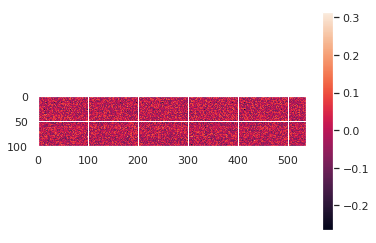

In [408]:
plt.imshow(ww);
plt.colorbar()

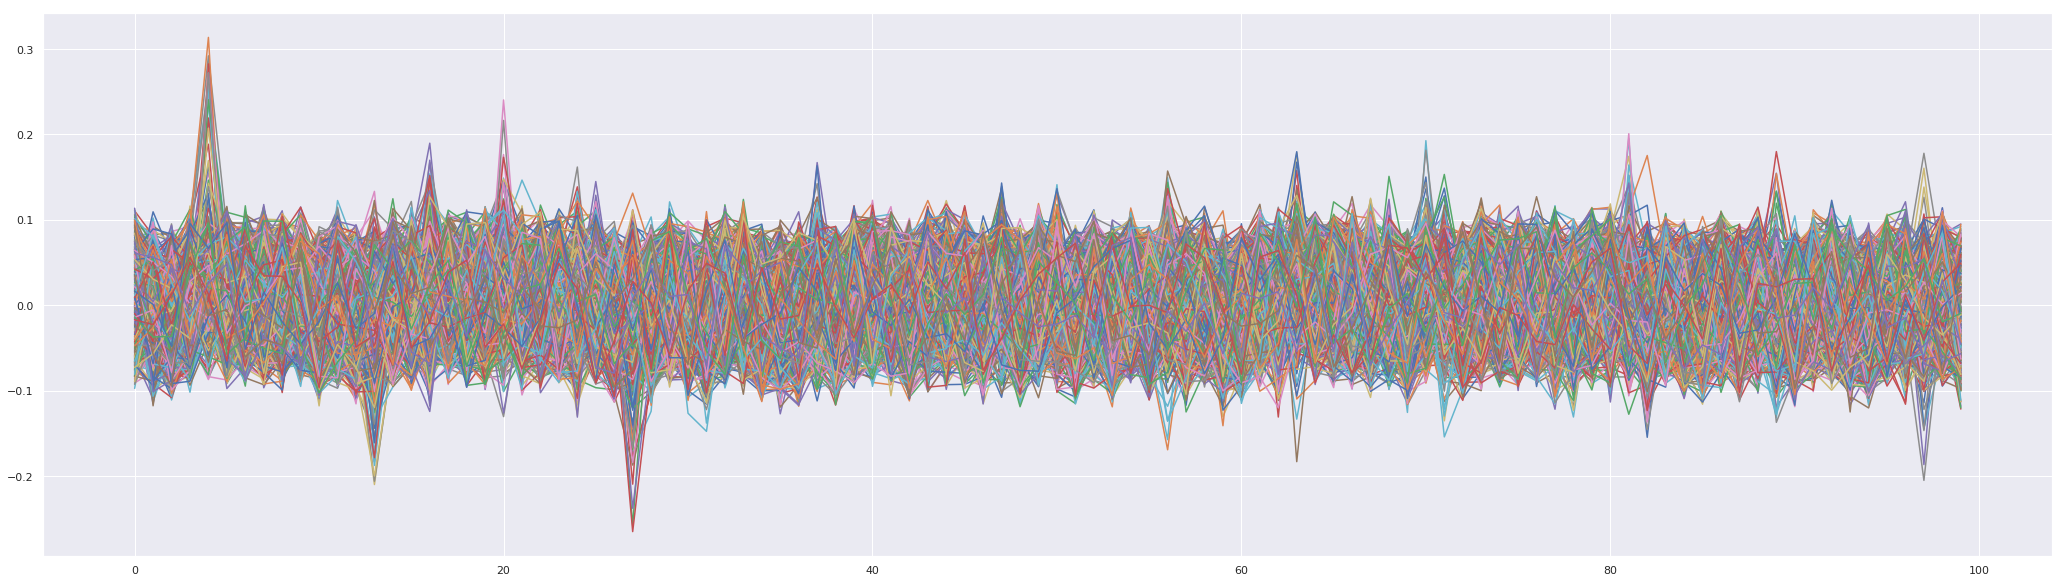

In [409]:

plt.figure(figsize=(36,10))

plt.plot(ww);


In [410]:
def gridSearch(grid,batch_sizes):
    for batch_size in batch_sizes :
        for model in grid:
            nSegments = len(speedDF)
            input_lag, output_lag, sequence_length = 4, 1, 20
            valid_split = 0.7
            params        = {"scale_max":True, "shift_mean":False}
            data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
            data_model_05 = models.DataModel( speedDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
            data_model_10 = models.DataModel( speedDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
            data_model.preprocessData()
            data_model_05.preprocessData()
            data_model_10.preprocessData()
            x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()
            x_train_05, y_train_05, x_test_05, y_test_05 = data_model.trainSplit()
            x_train_10, y_train_10, x_test_10, y_test_10 = data_model.trainSplit()
            x_train = np.concatenate([x_train_00,x_train_05,x_train_10])
            y_train = np.concatenate([y_train_00,y_train_05,y_train_10])
            count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
            count_train, _, count_test, _ = count_data.trainSplit()
            count_data_05 = models.DataModel( countDF_05, input_lag, output_lag, sequence_length, valid_split = valid_split)
            count_train_05, _, count_test_05, _ = count_data.trainSplit()
            count_data_10 = models.DataModel( countDF_10, input_lag, output_lag, sequence_length, valid_split = valid_split)
            count_train_10, _, count_test_10, _ = count_data.trainSplit()
            count_train =  np.concatenate([ count_train,
                                            count_train_05,
                                            count_train_10])
            data_model.count_data = count_data
            data_model.time_data=  data_model.getDaysTypes()
            train_days, test_days = data_model.time_data
            train_days_05, _ = data_model_05.getDaysTypes()
            train_days_10, _ = data_model_10.getDaysTypes()
            train_days= np.concatenate([train_days,train_days_05,train_days_10])
            tf.keras.backend.clear_session()
            config = tf.ConfigProto(intra_op_parallelism_threads=10, 
                                    inter_op_parallelism_threads=10,
                                    allow_soft_placement=True, 
                                    log_device_placement=True
                                   )
            session = tf.Session(config=config,graph=tf.get_default_graph())
            tf.keras.backend.set_session(session)

            data_model.model = createLSTM(*model,x_train,count_train,train_days)
            
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.2,
                                  patience=5, min_lr=0.0001)
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


            modelHist = data_model.model.fit([x_train,count_train,train_days],[y_train],validation_data=([x_test_00,count_test,test_days],y_test_00),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop],verbose=0)
            # modelHist = data_model.model.fit([x_train,train_days],[y_train],validation_data=([x_test,test_days],[y_test]),batch_size=batch_size,epochs=200,callbacks=[reduce_lr,early_stop])

            res[str(model)+"_"+str(batch_size)]=[modelHist.history,modelHist.params,
                                             data_model.mse(data_model.predict('train'),y_train_00),data_model.mse(data_model.predict('test'),y_test_00),
                                             data_model.mae(data_model.predict('train'),y_train_00),data_model.mae(data_model.predict('test'),y_test_00),
                                             model
                                            ]
            model_plotting = models.ModelPlots(data_model,data_cleaner)
                        
            model_plotting.cdfPlot(error_type="mape",label="mape")

            plt.legend()
            plt.savefig(str(model)+"_"+str(batch_size)+".png",dpi=300,bbox_inches='tight')
            plt.close("all")

In [411]:
my_grid = [
    
    [["flatten"],[100],["flatten"],[100],['dense'],[100]],
    [["flatten"],[200],["flatten"],[200],['dense'],[200]],
    [["flatten"],[300],["flatten"],[300],['dense'],[300]],

    [["flatten","dense"],[100,100],["flatten","dense"],[100,100],['dense'],[100]],
    [["flatten","dense"],[200,200],["flatten","dense"],[200,200],['dense'],[200]],
    [["flatten","dense"],[300,300],["flatten","dense"],[300,300],['dense'],[300]],
    
    [["flatten","dense"],[100,100],["flatten","dense"],[100,100],['dense',"dense"],[100,100]],
    [["flatten","dense"],[200,200],["flatten","dense"],[200,200],['dense',"dense"],[200,200]],
    [["flatten","dense"],[300,300],["flatten","dense"],[300,300],['dense',"dense"],[300,300]],
    
    [["flatten","dense","dense"],[100,100,100],["flatten","dense","dense"],[100,100,100],['dense'],[100]],
    [["flatten","dense","dense"],[200,200,200],["flatten","dense","dense"],[200,200,200],['dense'],[200]],
    [["flatten","dense","dense"],[300,300,300],["flatten","dense","dense"],[300,300,300],['dense'],[300]],
    
       
    [["flatten","dense","dense"],[100,100,100],["flatten","dense","dense"],[100,100,100],['dense',"dense"],[100,100]],
    [["flatten","dense","dense"],[200,200,200],["flatten","dense","dense"],[200,200,200],['dense',"dense"],[200,200]],
    [["flatten","dense","dense"],[300,300,300],["flatten","dense","dense"],[300,300,300],['dense',"dense"],[300,300]],   
    
    [["lstm"],[100],["lstm"],[100],['dense'],[100]],
    [["lstm"],[200],["lstm"],[200],['dense'],[200]],
    [["lstm"],[300],["lstm"],[300],['dense'],[300]],

    [["lstm","dense"],[100,100],["lstm","dense"],[100,100],['dense'],[100]],
    [["lstm","dense"],[200,200],["lstm","dense"],[200,200],['dense'],[200]],
    [["lstm","dense"],[300,300],["lstm","dense"],[300,300],['dense'],[300]],
    
    [["lstm","dense"],[100,100],["lstm","dense"],[100,100],['dense',"dense"],[100,100]],
    [["lstm","dense"],[200,200],["lstm","dense"],[200,200],['dense',"dense"],[200,200]],
    [["lstm","dense"],[300,300],["lstm","dense"],[300,300],['dense',"dense"],[300,300]],
    
    [["lstm","dense","dense"],[100,100,100],["lstm","dense","dense"],[100,100,100],['dense'],[100]],
    [["lstm","dense","dense"],[200,200,200],["lstm","dense","dense"],[200,200,200],['dense'],[200]],
    [["lstm","dense","dense"],[300,300,300],["lstm","dense","dense"],[300,300,300],['dense'],[300]],
    
        
    [["lstm","dense","dense"],[100,100,100],["lstm","dense","dense"],[100,100,100],['dense',"dense"],[100,100]],
    [["lstm","dense","dense"],[200,200,200],["lstm","dense","dense"],[200,200,200],['dense',"dense"],[200,200]],
    [["lstm","dense","dense"],[300,300,300],["lstm","dense","dense"],[300,300,300],['dense',"dense"],[300,300]],
 
]

In [ ]:
res={}
gridSearch(my_grid,batch_sizes=[20,10,5,2,3,8,15,25,30,50,64,1])


In [703]:
resdf=pd.DataFrame(res,index =["name","params","tmse","vmse","tmae","vmae","arch"]).T

In [ ]:
resdf.sort_values('vmae')

In [560]:
def createLSTM(speed_layers,speed_layers_units,count_layers,count_layers_units,merge_layers,merge_layers_units,x_train,count_train,train_days):
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")
    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    speed_layer =main_input
    count_layer=count_input
    for x,n_units in zip(speed_layers,speed_layers_units) :
        if x.lower() == "lstm":
            speed_layer= tf.keras.layers.LSTM(n_units)(speed_layer)
        if x.lower() == "dense":
            speed_layer= tf.keras.layers.Dense(n_units,activation="sigmoid")(speed_layer)
        if x.lower() == "dropout":
            speed_layer= tf.keras.layers.Dropout(n_units)(speed_layer)
        if x.lower() == "flatten":
            speed_layer= tf.keras.layers.Flatten()(speed_layer)
    for x,n_units in zip( count_layers,count_layers_units ):
        if x.lower() == "lstm":
            count_layer= tf.keras.layers.LSTM(n_units)(count_layer)
        if x.lower() == "dense":
            count_layer= tf.keras.layers.Dense(n_units,activation="sigmoid")(count_layer)
        if x.lower() == "dropout":
            count_layer= tf.keras.layers.Dropout(n_units)(count_layer)
        if x.lower() == "flatten":
            count_layer= tf.keras.layers.Flatten()(count_layer)           

    layer = tf.keras.layers.Concatenate(1,name="count_speed_merge")([speed_layer, count_layer,daytime_input])
        

    for x,n_units in  zip(merge_layers,merge_layers_units ):
        if x.lower() == "dense":
            layer= tf.keras.layers.Dense(n_units,activation="sigmoid")(layer)
        if x.lower() == "dropout":
            layer= tf.keras.layers.Dropout(n_units)(layer)
    
    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(layer)


    model =tf.keras.Model(inputs = [main_input,count_input,daytime_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=smape_loss, optimizer=optimizer)
    return model

191

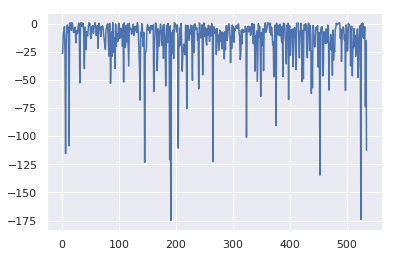

In [412]:
plt.plot(r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00),multioutput="raw_values"))
r2s =r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00),multioutput="raw_values").round(3)
r2s.argmin()

In [413]:
r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00),multioutput="variance_weighted")

-1.282449791632205

In [414]:
r2_score(data_model.predict('test'),data_model.getYAtStep(y_test_00),multioutput="variance_weighted")

-1.9045132136166276

In [415]:
from sklearn.metrics import r2_score
print(r2_score(data_model.getRawYData(data_model.predict('test')),data_model.getRawYData(data_model.getYAtStep(y_test_00))))
r2_score(data_model.predict('train'),data_model.getYAtStep(y_train_00))

-18.242641952714884


-14.227376706898152

In [416]:
models= reload(models)
model_plotting = models.ModelPlots(data_model, data_cleaner)
# model_plotting = models.ModelPlots(data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))


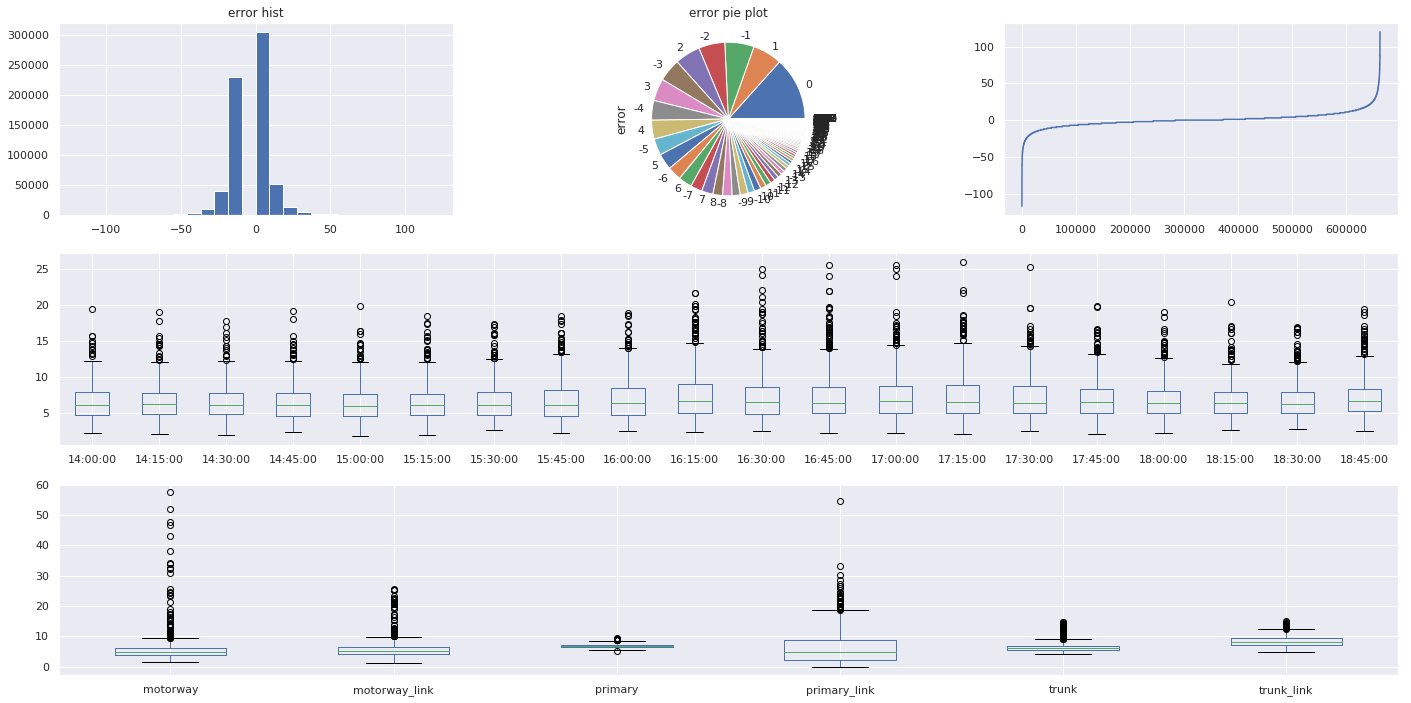

In [417]:
yDF=data_model.restorePredictionsAsDF(data_model.getYAtStep(data_model.y))
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

time_error_df  = abs(predDF-yDF).groupby(pd.DatetimeIndex(abs(predDF-yDF).columns).time,axis=1).mean()

tag_error_df  = abs(predDF-yDF).assign(tag = data_cleaner.segments_tags).groupby('tag').mean()

fig=plt.figure(figsize=(24,12))
gs = matplotlib.gridspec.GridSpec(3, 3, figure=fig)
fig.add_subplot(gs[0, 0])
int_err = (data_model.getRawYData(data_model.predict('full')).flatten() - data_model.getRawYData(data_model.getYAtStep(data_model.y)).flatten()).astype(int)
err_series = pd.Series(int_err).value_counts()
plt.hist(int_err//10*10,bins=26);
plt.title("error hist");
fig.add_subplot(gs[0, 1])
err_series.plot("pie",label="error")
plt.title("error pie plot");
int_err.sort()
fig.add_subplot(gs[0, 2])
plt.plot(int_err)
fig.add_subplot(gs[1,:])
time_error_df.boxplot(figsize=(18,6));
fig.add_subplot(gs[2,:])
tag_error_df.T.boxplot(figsize=(18,6));
# saveFig()

In [42]:
model_plotting.plotSegmentSeries(265,plot_surface=True)
model_plotting.plotSegmentSeries(265)
data_cleaner.plotSegmentComponents(265)

NameError: name 'model_plotting' is not defined

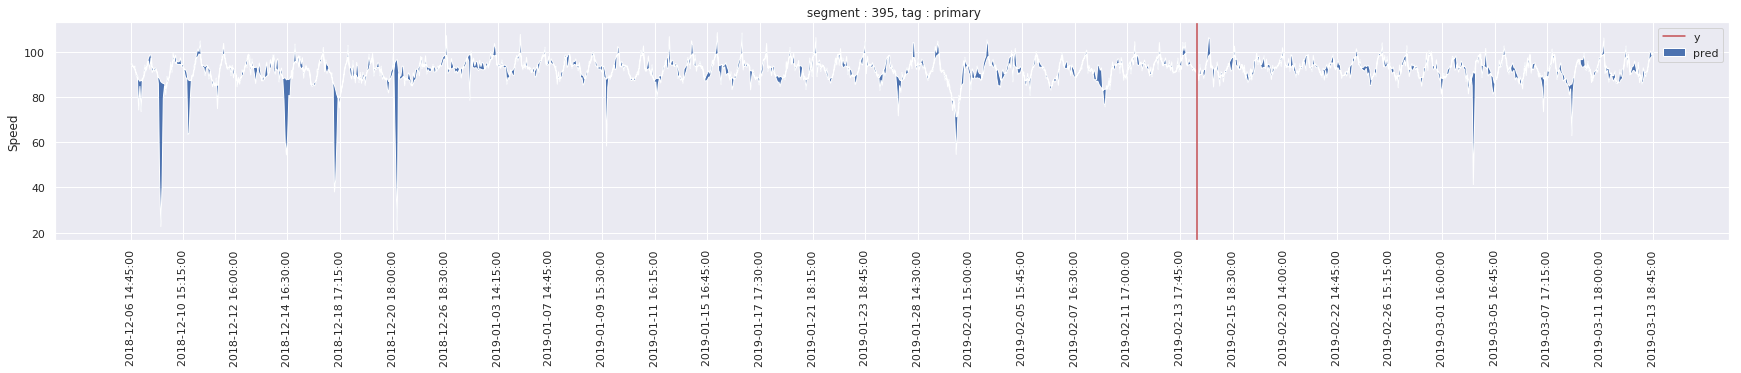

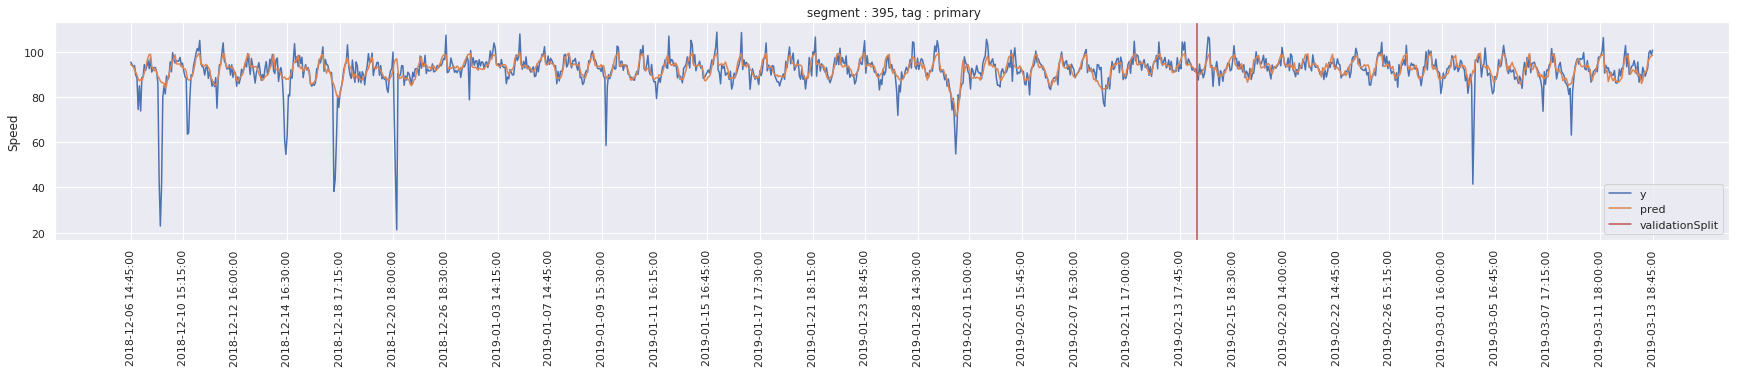

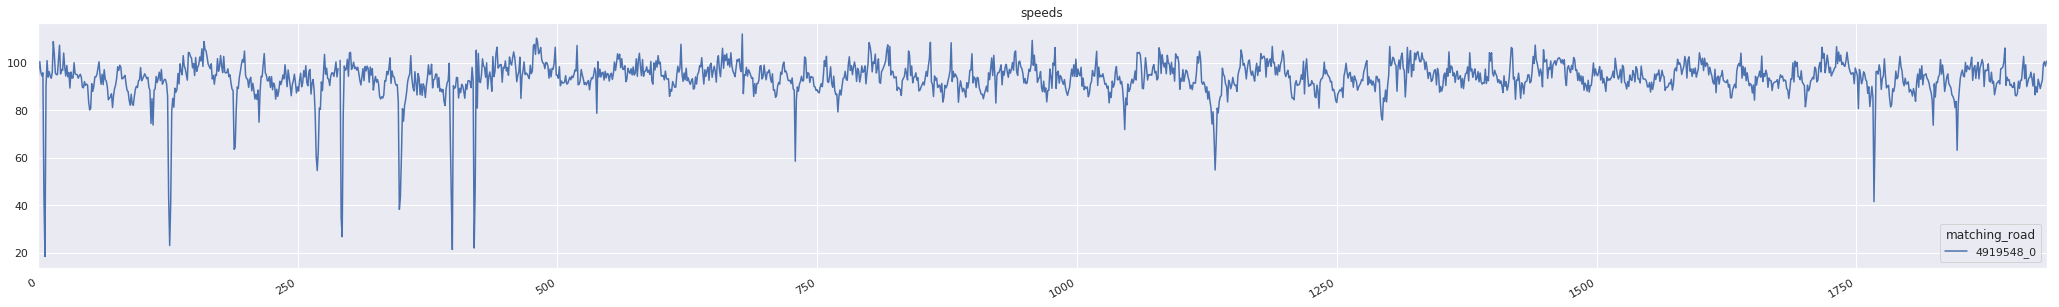

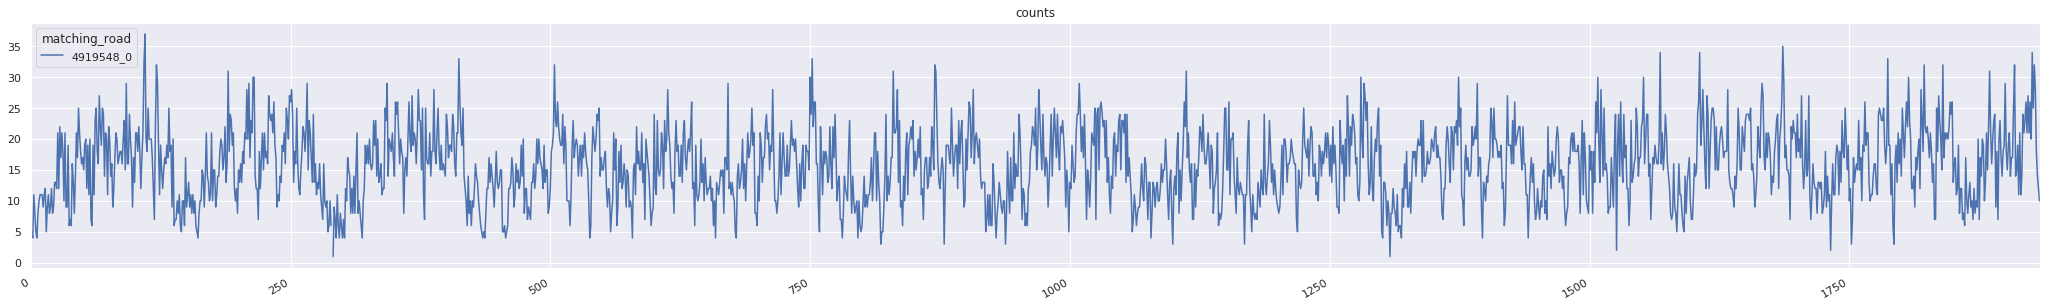

In [419]:
model_plotting.plotSegmentSeries(395,plot_surface=True)
model_plotting.plotSegmentSeries(395)
data_cleaner.plotSegmentComponents(395)

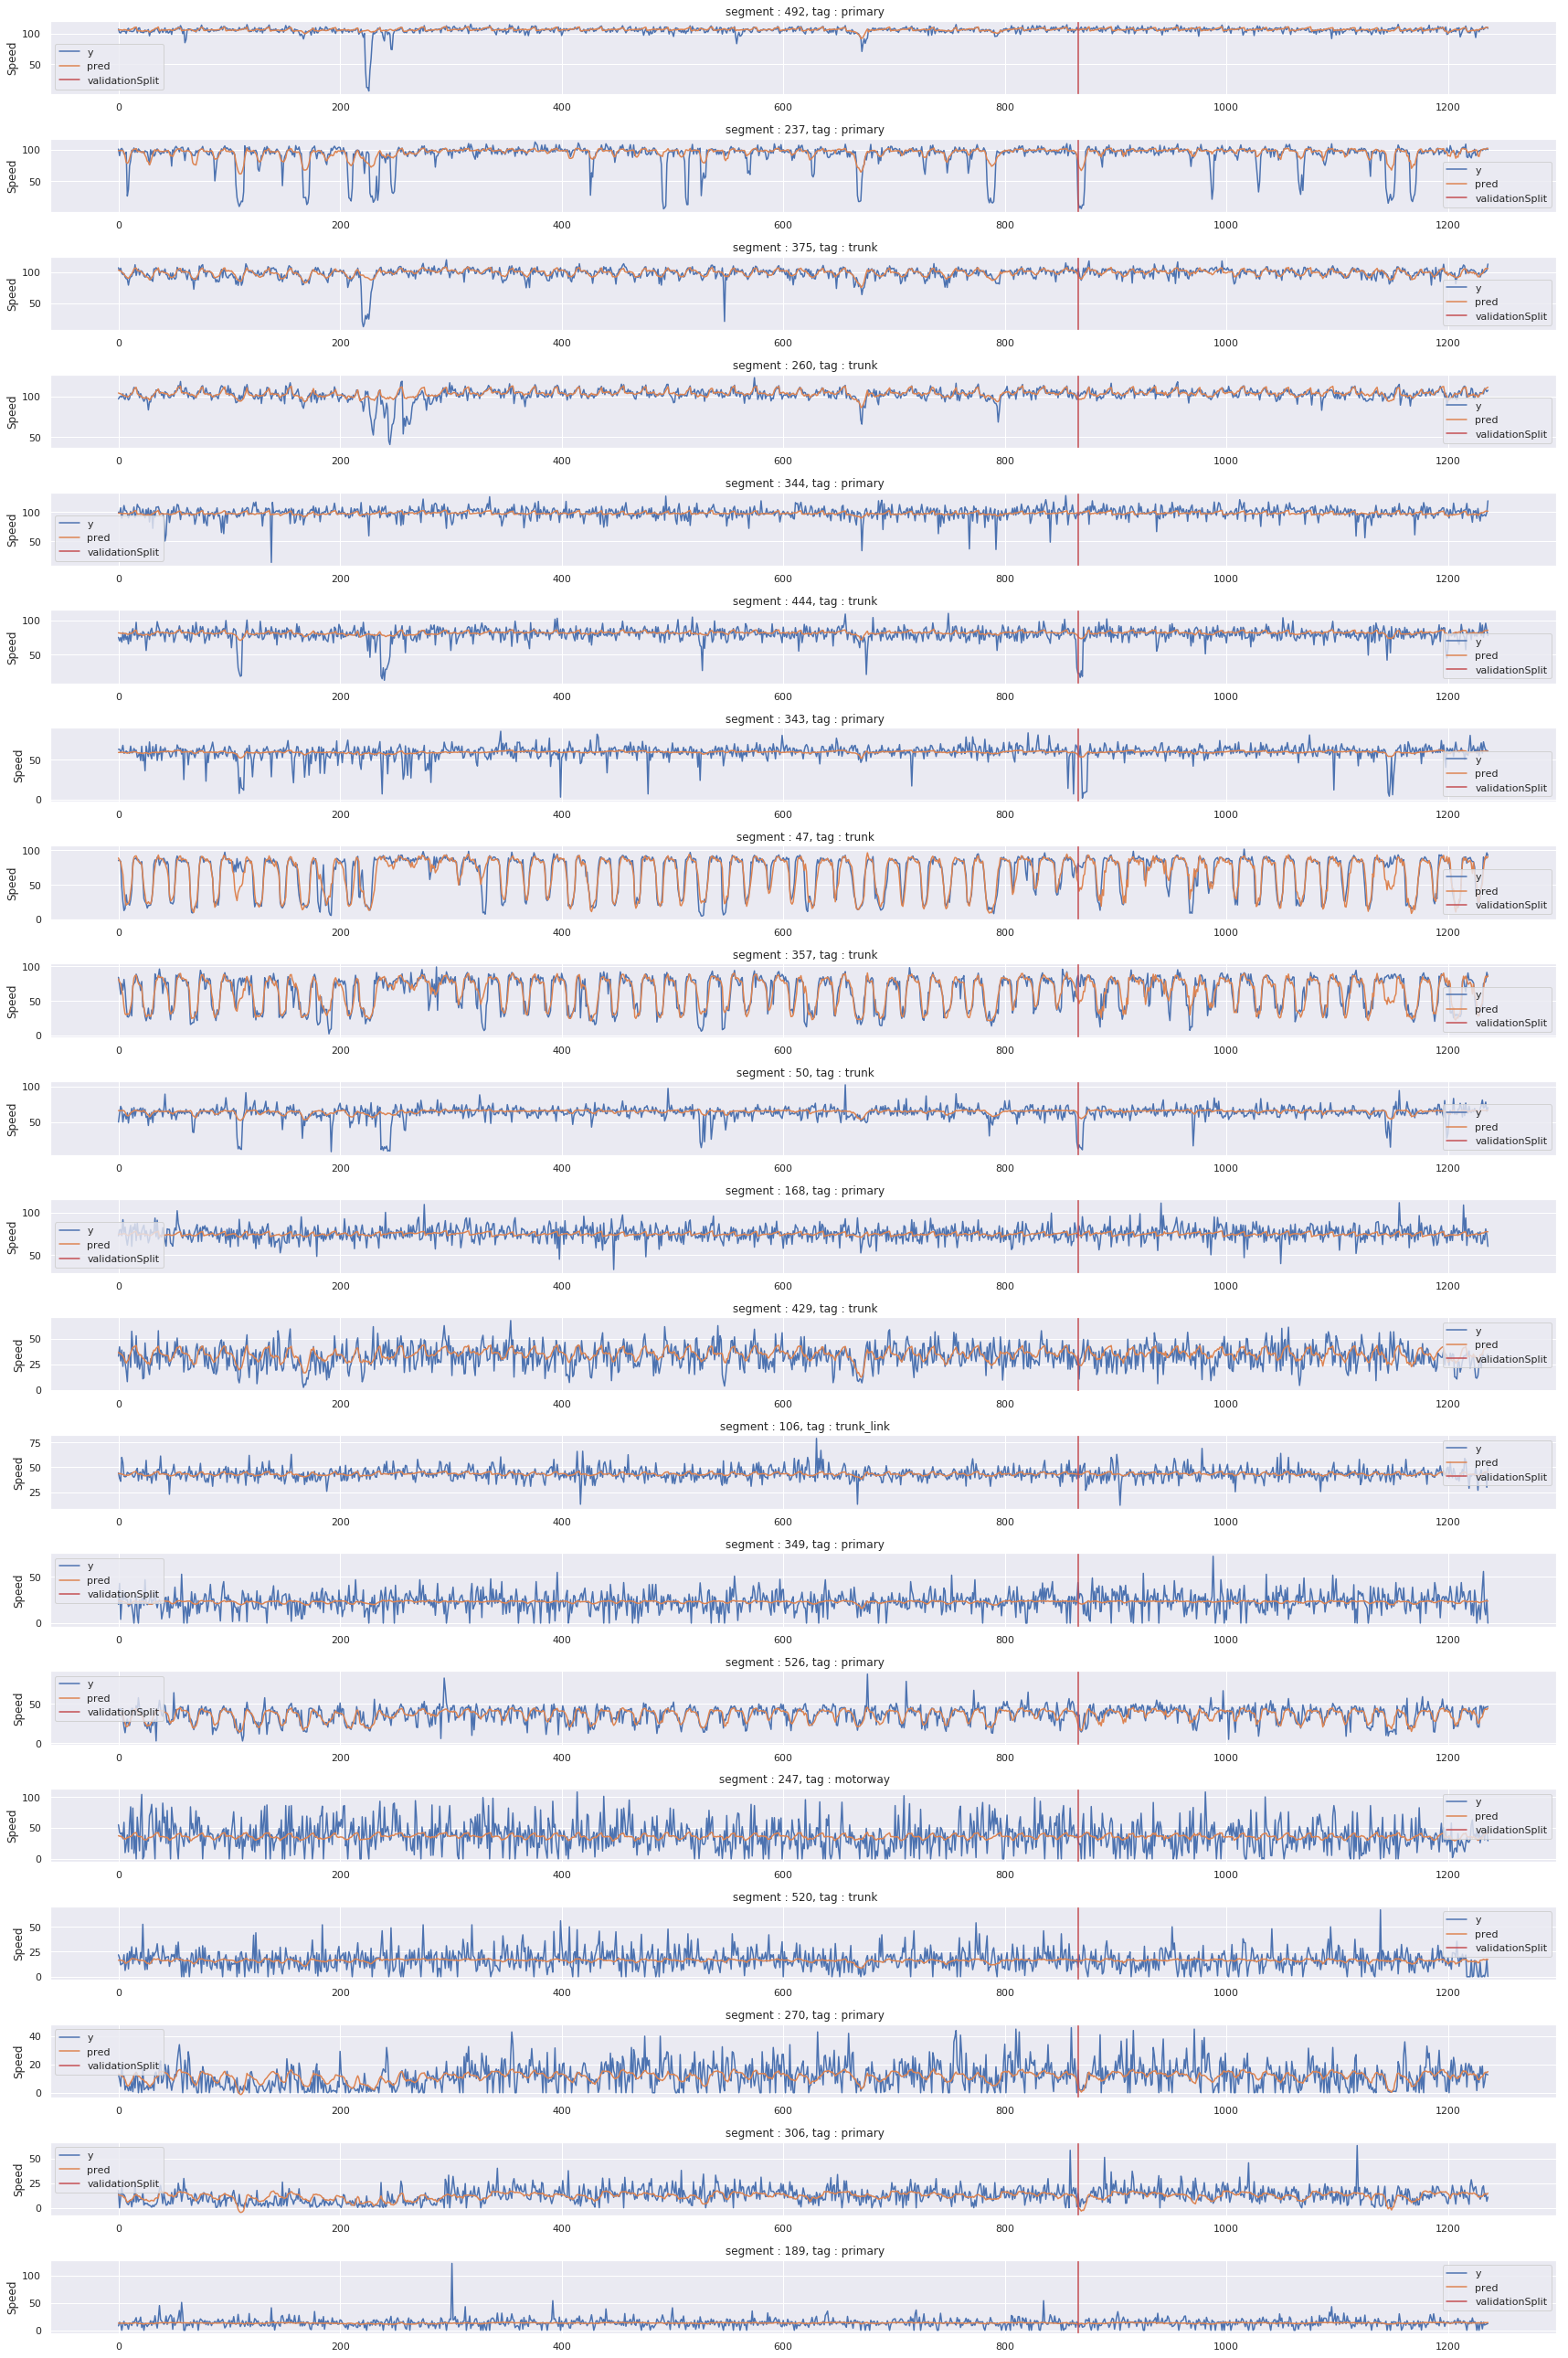

In [420]:
model_plotting.plotMultipleSegmentsSeries()

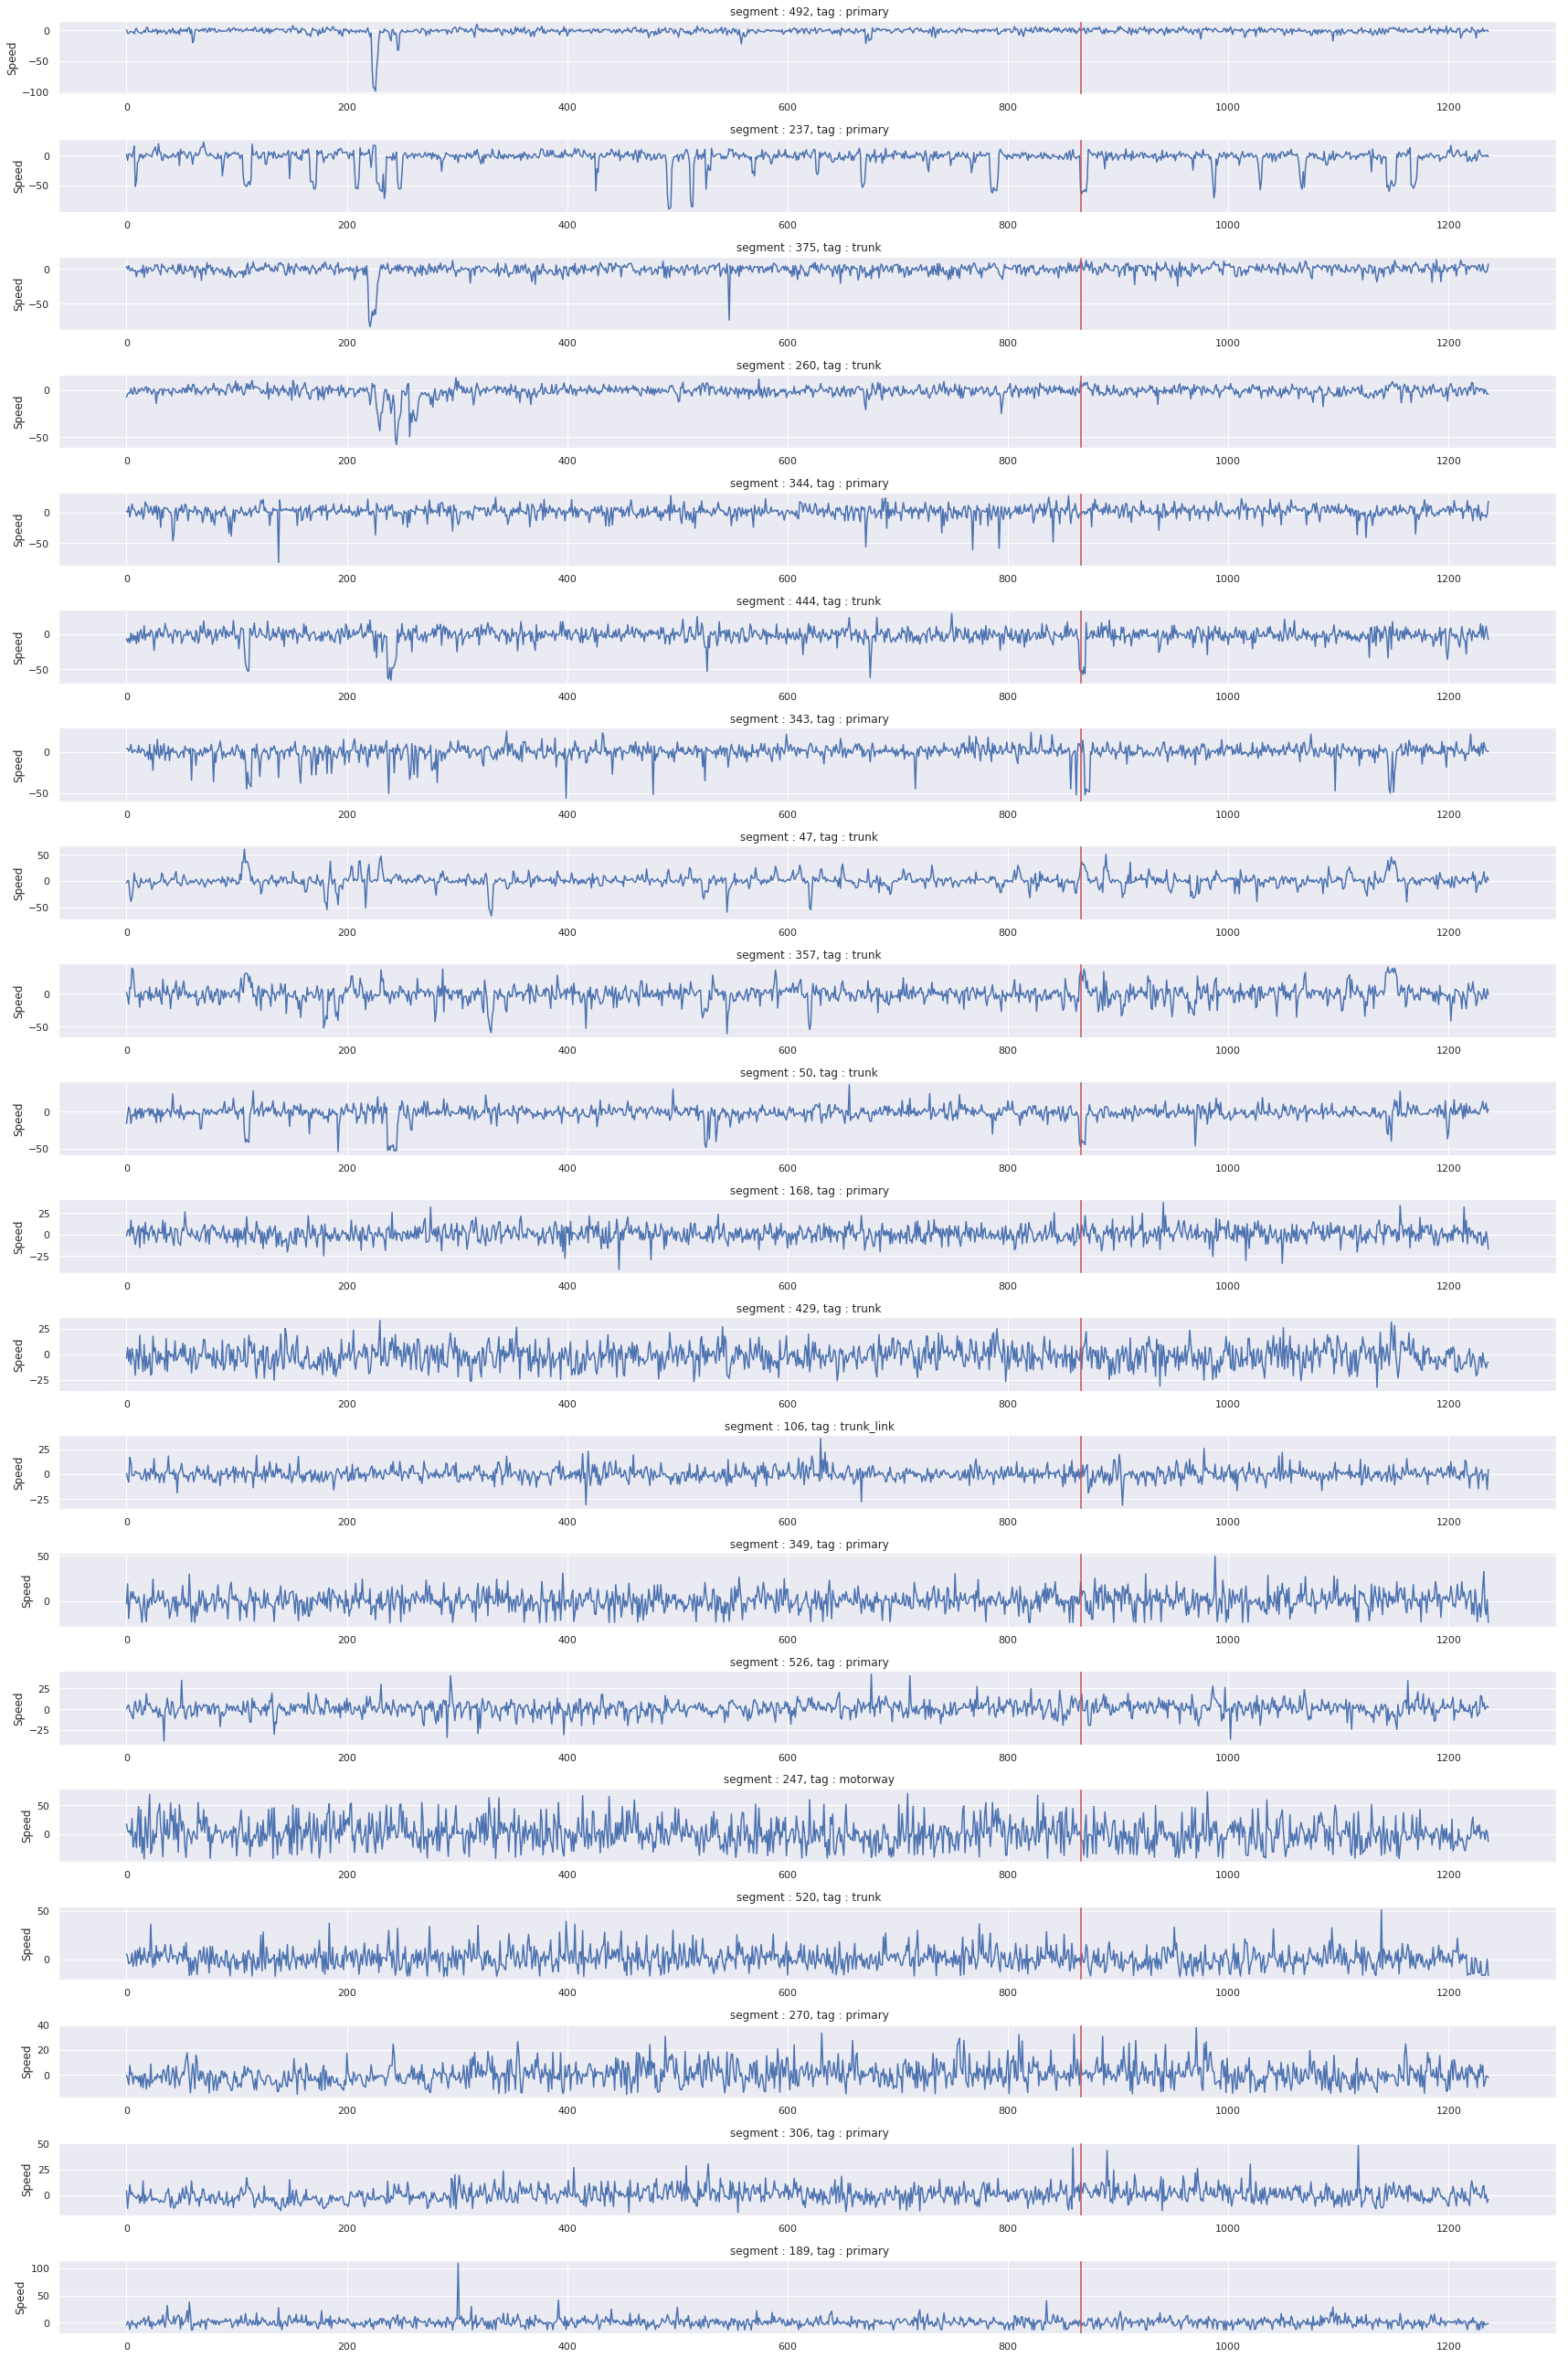

In [421]:
model_plotting.plotMultipleSegmentsSeries(plot_error=True)

In [47]:
tf.keras.regularizers.L1L2??

Init signature: tf.keras.regularizers.L1L2(l1=0.0, l2=0.0)
Source:        
class L1L2(Regularizer):
  """Regularizer for L1 and L2 regularization.

  Arguments:
      l1: Float; L1 regularization factor.
      l2: Float; L2 regularization factor.
  """

  def __init__(self, l1=0., l2=0.):  # pylint: disable=redefined-outer-name
    self.l1 = K.cast_to_floatx(l1)
    self.l2 = K.cast_to_floatx(l2)

  def __call__(self, x):
    regularization = 0.
    if self.l1:
      regularization += math_ops.reduce_sum(self.l1 * math_ops.abs(x))
    if self.l2:
      regularization += math_ops.reduce_sum(self.l2 * math_ops.square(x))
    return regularization

  def get_config(self):
    return {'l1': float(self.l1), 'l2': float(self.l2)}
File:           ~/.local/lib/python3.6/site-packages/tensorflow/python/keras/regularizers.py
Type:           type
Subclasses:     


In [48]:
tf.keras.layers.Layer??

Init signature: tf.keras.layers.Layer(trainable=True, name=None, dtype=None, **kwargs)
Source:        
class Layer(checkpointable.CheckpointableBase):
  """Base layer class.

  This is the class from which all layers inherit.

  A layer is a class implementing common neural networks operations, such
  as convolution, batch norm, etc. These operations require managing weights,
  losses, updates, and inter-layer connectivity.

  Users will just instantiate a layer and then treat it as a callable.

  We recommend that descendants of `Layer` implement the following methods:

  * `__init__()`: Save configuration in member variables
  * `build()`: Called once from `__call__`, when we know the shapes of inputs
    and `dtype`. Should have the calls to `add_weight()`, and then
    call the super's `build()` (which sets `self.built = True`, which is
    nice in case the user wants to call `build()` manually before the
    first `__call__`).
  * `call()`: Called in `__call__` after making sure `

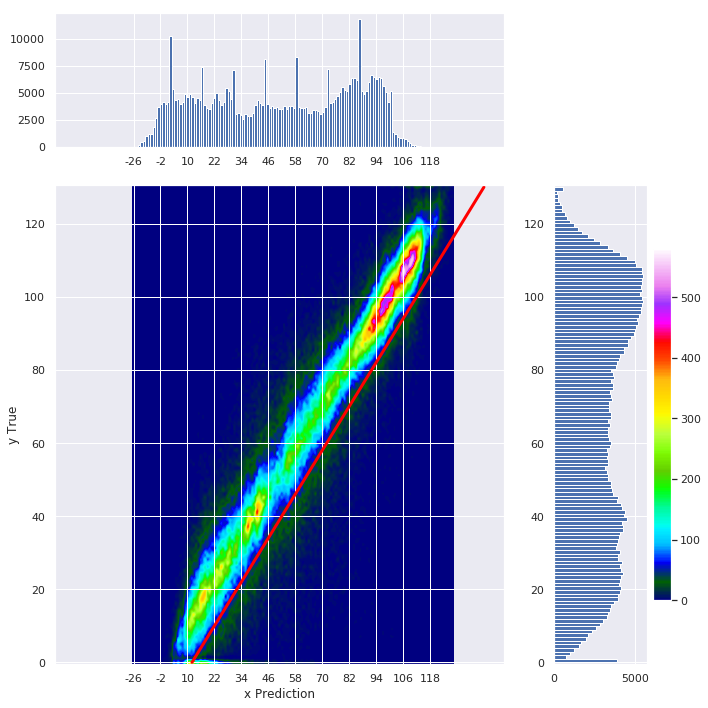

In [422]:
model_plotting.plotPredictionMatchHeatMap("train")
# saveFig()

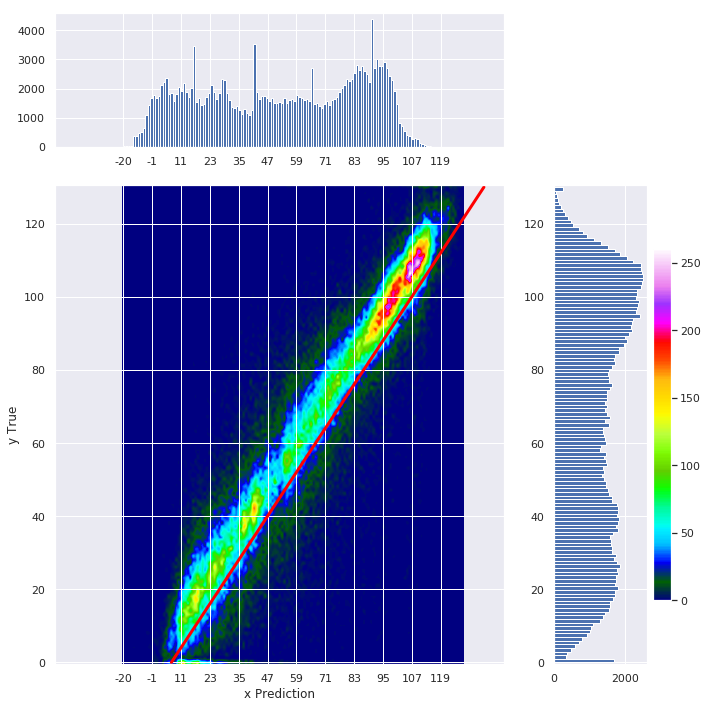

In [423]:
model_plotting.plotPredictionMatchHeatMap("valid")


In [446]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

# folium_map = plotPredictions(segmentsMeta,data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)],mergedIndex,updatedcounts)
folium_map=folium.plugins.DualMap(location=[48.10301,-1.65537],
                    zoom_start=13,
                    tiles="OpenStreetMap")

folium.features.LinearColormap([plt.cm.brg_r(0),plt.cm.brg_r(0.5)],caption="Error rate").add_to(folium_map.m1)

folium_train_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[8:14:1].astype(int)],folium_map=folium_map.m1)
folium_validation_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[len(yDF.columns)*valid_split+8:len(yDF.columns)*valid_split+14:1].astype(int)],folium_map=folium_map.m2)

folium_map.save(results_path+model_name+input()+' map.html')

 five minutes preds


In [461]:
predSegs = segmentsMeta[segmentsMeta.segmentID.isin(mergedIndex[mergedIndex.isin(speedDF.index)].index)]


In [119]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

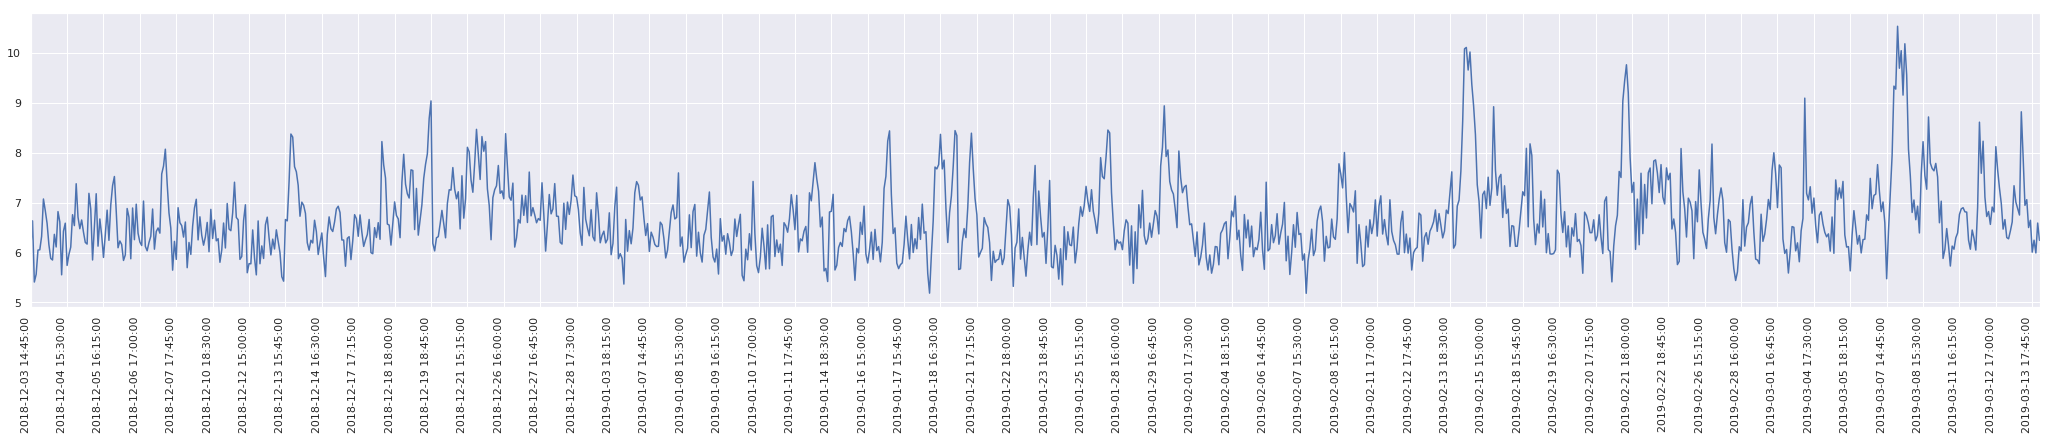

In [120]:
_20_error=abs(predDF-yDF)
_20_error.mean().plot(use_index=False,figsize=(36,6))
plt.xticks(*list(zip(*list(enumerate(predDF.columns))[::20])),rotation=90);

In [121]:
_20_error=abs(predDF-yDF)>20

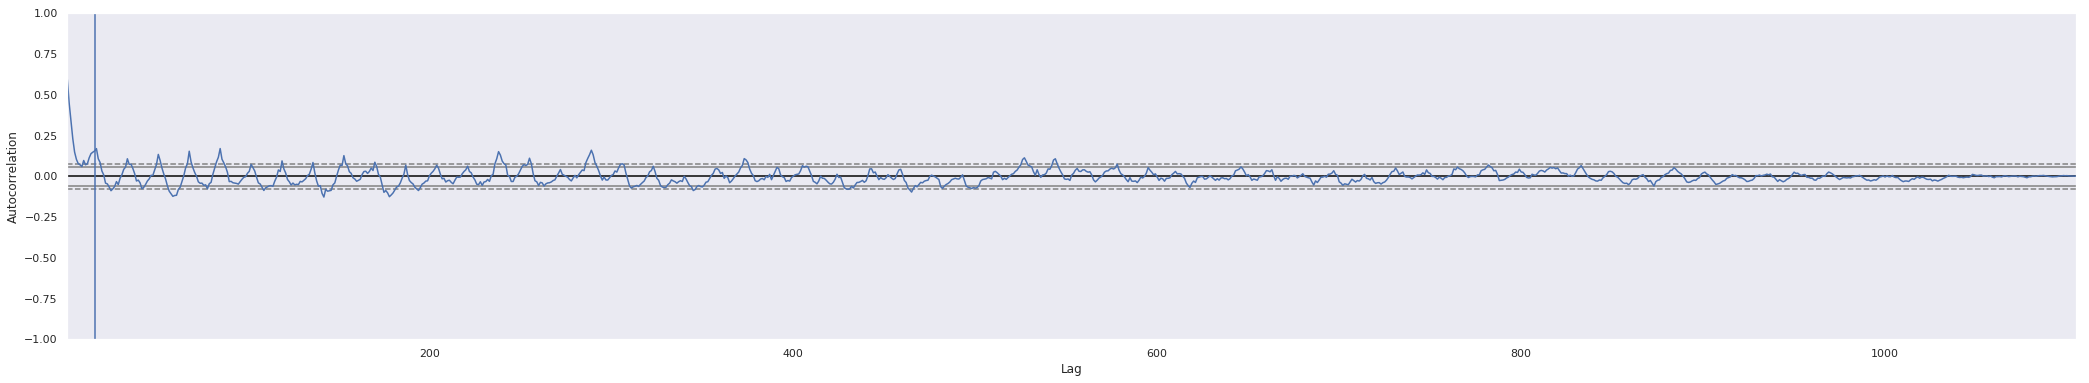

In [122]:
plt.figure(figsize=(36,6))
pd.plotting.autocorrelation_plot(_20_error.mean())
plt.axvline(16)

In [123]:
speedDF.shape

(536, 1300)

In [124]:
_20_error.sum(axis=1).values[np.where(_20_error.sum(axis=1).values>80)[0]]

array([ 93, 116,  99, 150, 140,  96, 301,  84,  85, 112, 107,  89, 177,
       113,  88, 129,  97, 265, 152, 197, 152, 180,  99, 144, 306, 153,
       127, 145,  81,  94, 111, 172, 121, 322,  94, 149,  82, 221, 116,
        84, 205, 103, 116, 114, 166, 108, 216,  90, 142, 168, 217,  91,
        91, 104,  90,  91, 304, 178, 377, 188,  94, 284, 101,  99, 191,
       270, 172, 238, 176, 121, 166, 143,  89, 132,  99, 120, 219, 105,
       241, 115, 103, 118,  85, 109, 177, 140, 197, 105,  86,  92, 100,
       206, 106,  99, 165, 118, 172, 149, 157,  86, 133, 111, 326, 102,
       159, 112, 260, 138, 175,  83, 108, 104, 127, 174, 164, 160,  81,
       110,  96,  90, 107, 238, 107, 162, 132])

In [125]:
np.where(_20_error.sum(axis=1).values>80)[0]

array([  1,  12,  13,  14,  17,  18,  30,  32,  33,  34,  36,  47,  48,
        51,  62,  65,  73,  74,  75,  83,  84,  94,  98,  99, 110, 111,
       116, 118, 119, 122, 128, 129, 132, 133, 136, 140, 143, 153, 160,
       164, 165, 170, 172, 173, 177, 181, 184, 194, 197, 198, 199, 203,
       215, 216, 218, 241, 242, 243, 247, 250, 251, 273, 275, 285, 288,
       292, 295, 296, 297, 301, 302, 308, 309, 313, 315, 324, 333, 336,
       345, 357, 358, 359, 362, 363, 366, 389, 390, 397, 406, 407, 410,
       412, 413, 414, 415, 420, 426, 436, 441, 443, 447, 458, 475, 476,
       477, 478, 481, 484, 486, 487, 488, 489, 495, 501, 503, 505, 507,
       508, 509, 510, 516, 525, 528, 533, 534])

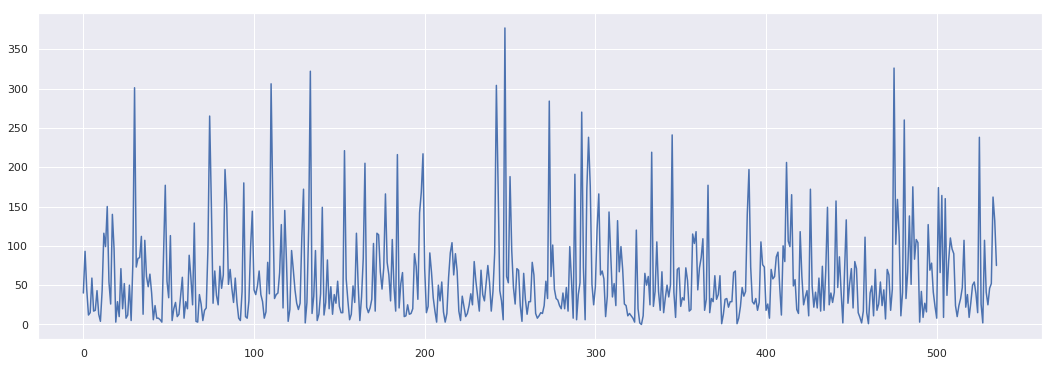

In [127]:
plt.figure(figsize=(18,6))
plt.plot(_20_error.sum(axis=1).values)

In [128]:
error = data_model.getRawYData(data_model.predict("test").clip(0)) - data_model.getRawYData(y_test_00)

In [129]:
round_error= abs(error.flatten().round())//5*5

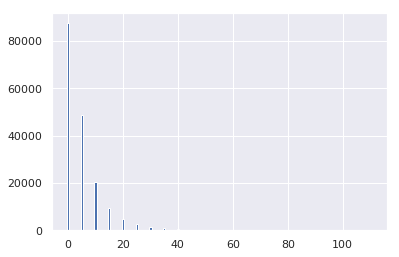

In [130]:
plt.bar(*np.unique(round_error,return_counts=True),);

In [131]:
pd.DataFrame(np.unique(round_error,return_counts=True),index=["error range","number of occurrences" ])

0        1        2       3       4       5   \
error range                0.0      5.0     10.0    15.0    20.0    25.0   
number of occurrences  87571.0  48963.0  20634.0  9635.0  4777.0  2527.0   

                           6      7      8      9   ...    13    14    15  \
error range              30.0   35.0   40.0   45.0  ...  65.0  70.0  75.0   
number of occurrences  1426.0  920.0  510.0  310.0  ...  56.0  59.0  35.0   

                         16    17    18    19     20     21     22  
error range            80.0  85.0  90.0  95.0  100.0  105.0  110.0  
number of occurrences  24.0  11.0  13.0   9.0    6.0    2.0    3.0  

[2 rows x 23 columns]

Text(0.5, 1.0, 'error distribution')

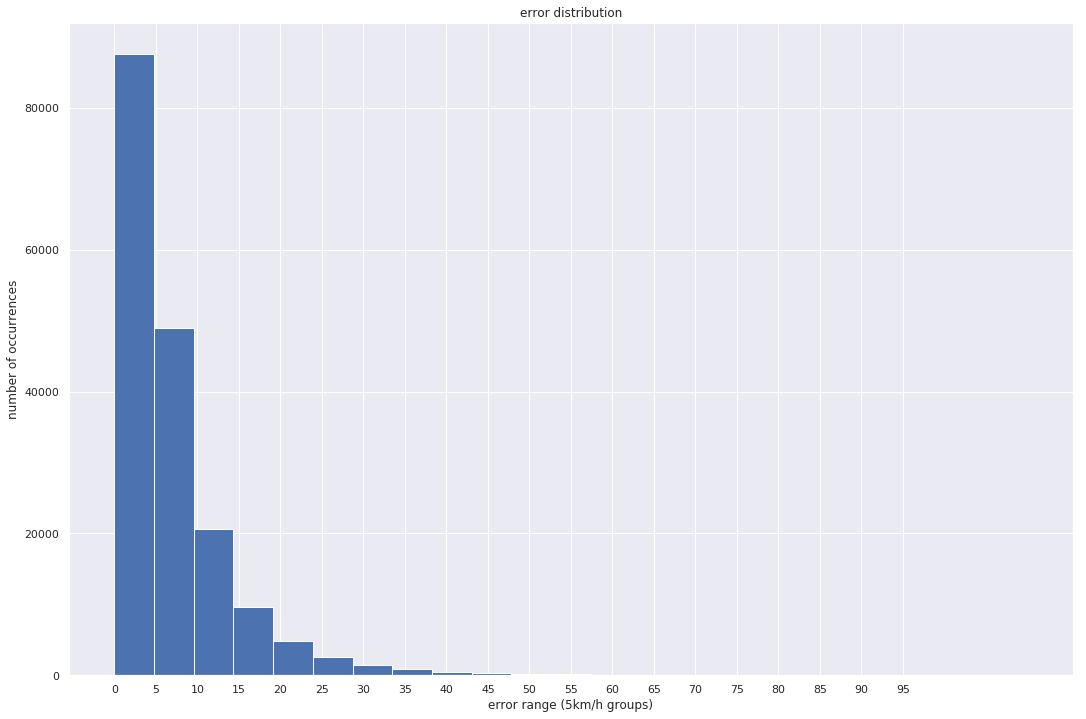

In [132]:
plt.figure(figsize=(18,12))
plt.hist(sorted(round_error),bins=23);
plt.xticks(range(0,100,5),range(0,100,5));
plt.xlabel("error range (5km/h groups)")
plt.ylabel("number of occurrences")
plt.title("error distribution")

In [133]:

params        = {}

lastValue_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
lastValue_data_model.preprocessData()

model =models.BaseModels("lastValue",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
lastValue_data_model.model=model
lastValue_model_plotting = models.ModelPlots(lastValue_data_model, data_cleaner)


In [134]:

params        = {}

timehistoric_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
timehistoric_data_model.preprocessData()

model =models.BaseModels("timeHistoric",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
timehistoric_data_model.model=model


In [135]:

params        = {}

historic_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
historic_data_model.preprocessData()

model =models.BaseModels("historic",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]])
historic_data_model.model=model


In [136]:
params        = {}

AR5_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
AR5_data_model.preprocessData()

model =models.BaseModels("AR5",historic_data=speedDF[speedDF.columns[:int(0.7*len(speedDF.columns))]],lag=input_lag)
AR5_data_model.model=model


Training the AR(5) model
Train data shape: (536, 909)

Filling the voids...
Filling done. New train data shape: (536, 6921)

Training the models...
Params: max_lag: 3


/home/infres/mbouchouia/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)



Training finished !


In [137]:
# mlp_model_plotting = models.ModelPlots(mlpModel, data_cleaner, split="test", y=data_model.getRawYData(y_test_00))
lastValue_model_plotting = models.ModelPlots(lastValue_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
historic_model_plotting = models.ModelPlots(historic_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
timehistoric_model_plotting = models.ModelPlots(timehistoric_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
AR5_model_plotting = models.ModelPlots(AR5_data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))
model_plotting = models.ModelPlots(data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))


In [424]:
model_plotting = models.ModelPlots(data_model,data_cleaner,split="test",y=data_model.getRawYData(y_test_00))


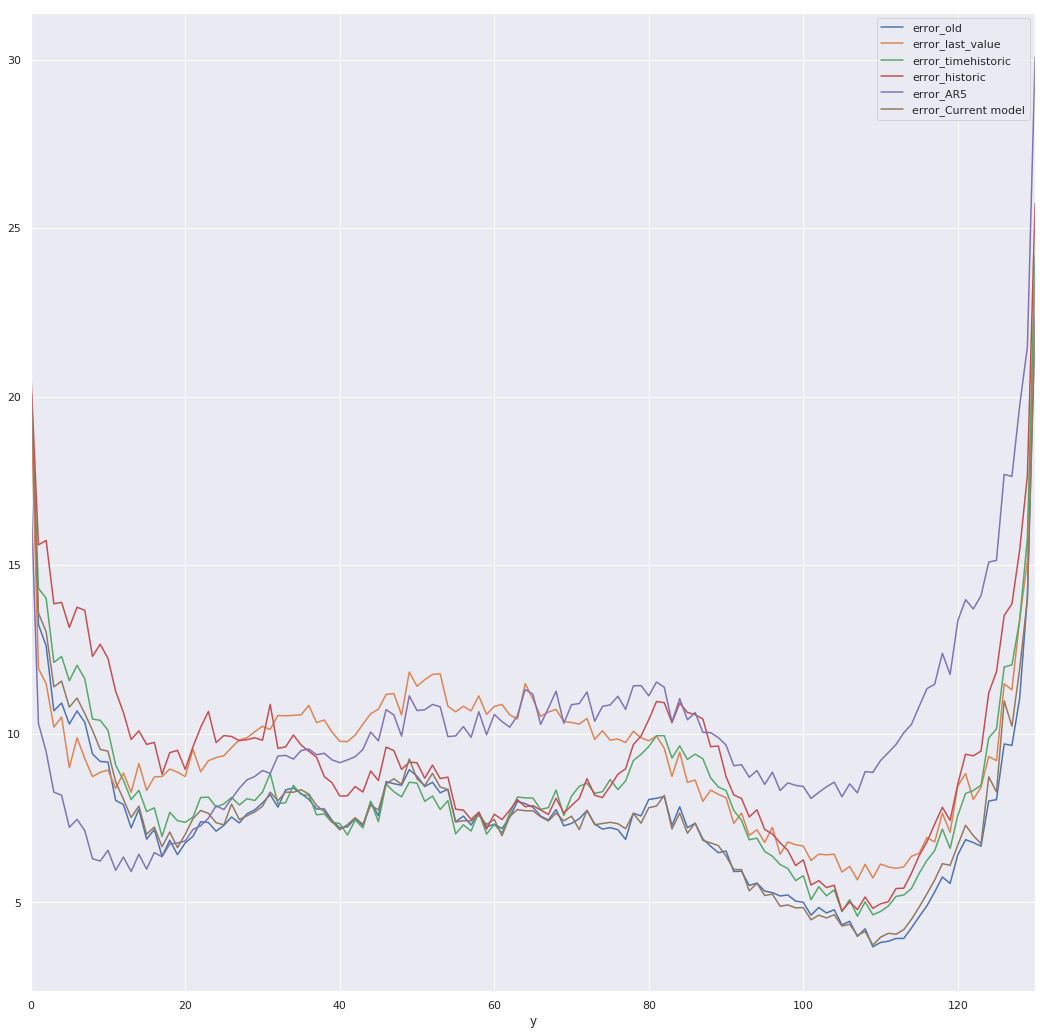

In [425]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
oldModelPlotting.plotDiscreteSpeedError(ax,"old")
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
model_plotting.plotDiscreteSpeedError(ax,"Current model")

In [ ]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
oldModelPlotting.plotDiscreteSpeedError(ax,"old")
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
model_plotting.plotDiscreteSpeedError(ax,"Current model")

In [ ]:
plt.figure(figsize=(18,18))
oldModelPlotting.cdfPlot(error_type="mape",label="old",plot_lines=False)
lastValue_model_plotting.cdfPlot(error_type="mape",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mape",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mape",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mape",label="AR5",plot_lines=False)
model_plotting.cdfPlot(error_type="mape",label="current",plot_lines=False)


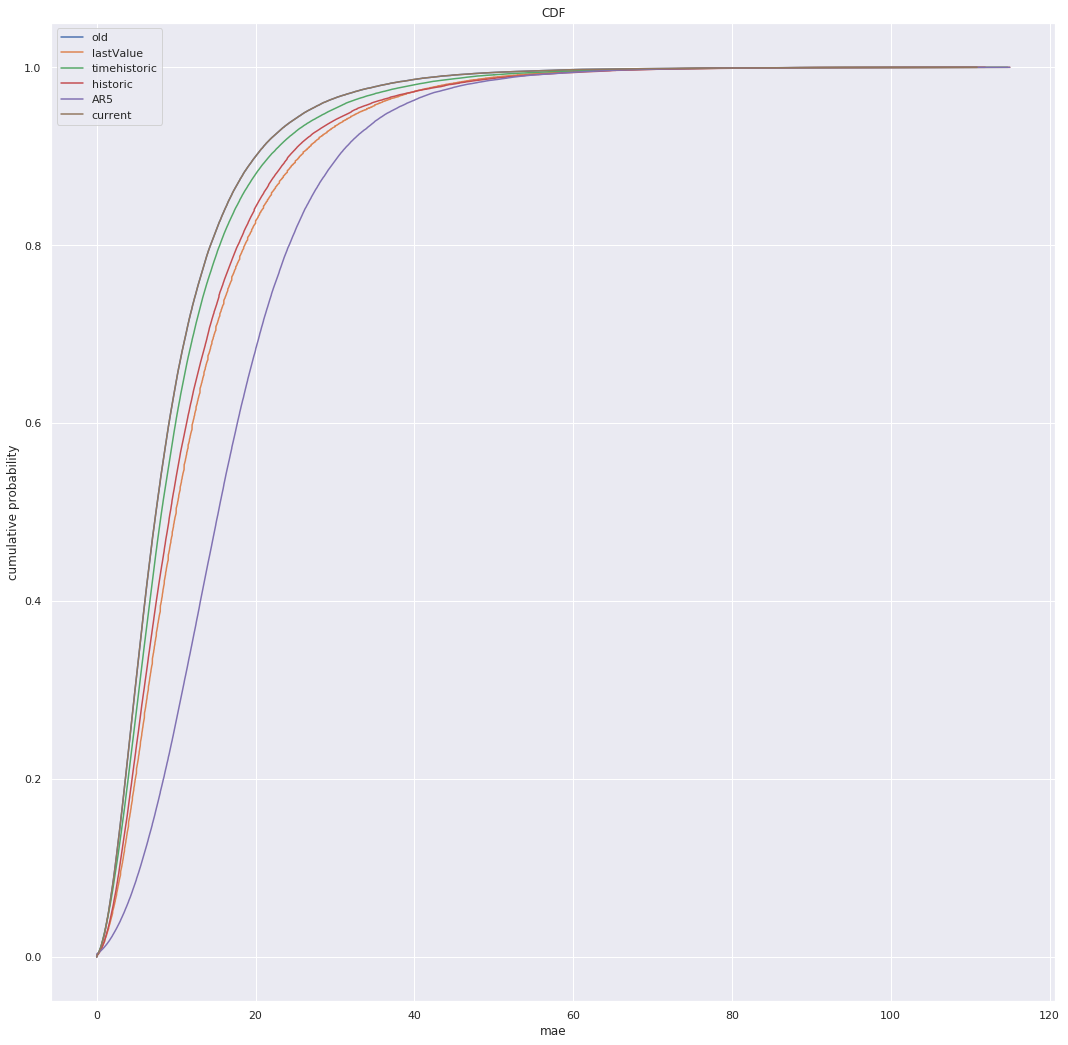

In [76]:
plt.figure(figsize=(18,18))
oldModelPlotting.cdfPlot(error_type="mae",label="old",plot_lines=False)
lastValue_model_plotting.cdfPlot(error_type="mae",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mae",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mae",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mae",label="AR5",plot_lines=False)
model_plotting.cdfPlot(error_type="mae",label="current",plot_lines=False)

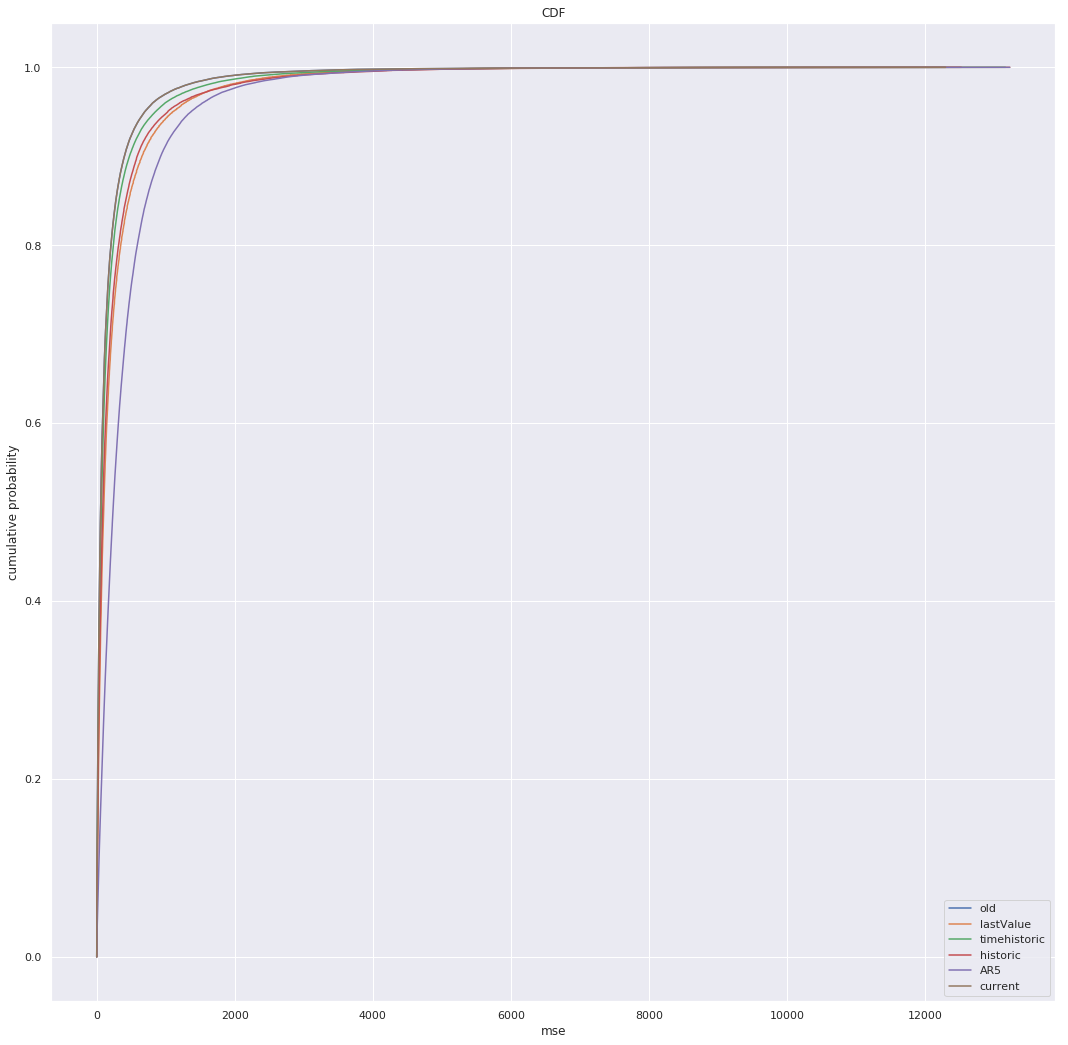

In [77]:
plt.figure(figsize=(18,18))
oldModelPlotting.cdfPlot(error_type="mse",label="old",plot_lines=False)
lastValue_model_plotting.cdfPlot(error_type="mse",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mse",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mse",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mse",label="AR5",plot_lines=False)
model_plotting.cdfPlot(error_type="mse",label="current",plot_lines=False)


In [141]:
oldModelPlotting = model_plotting

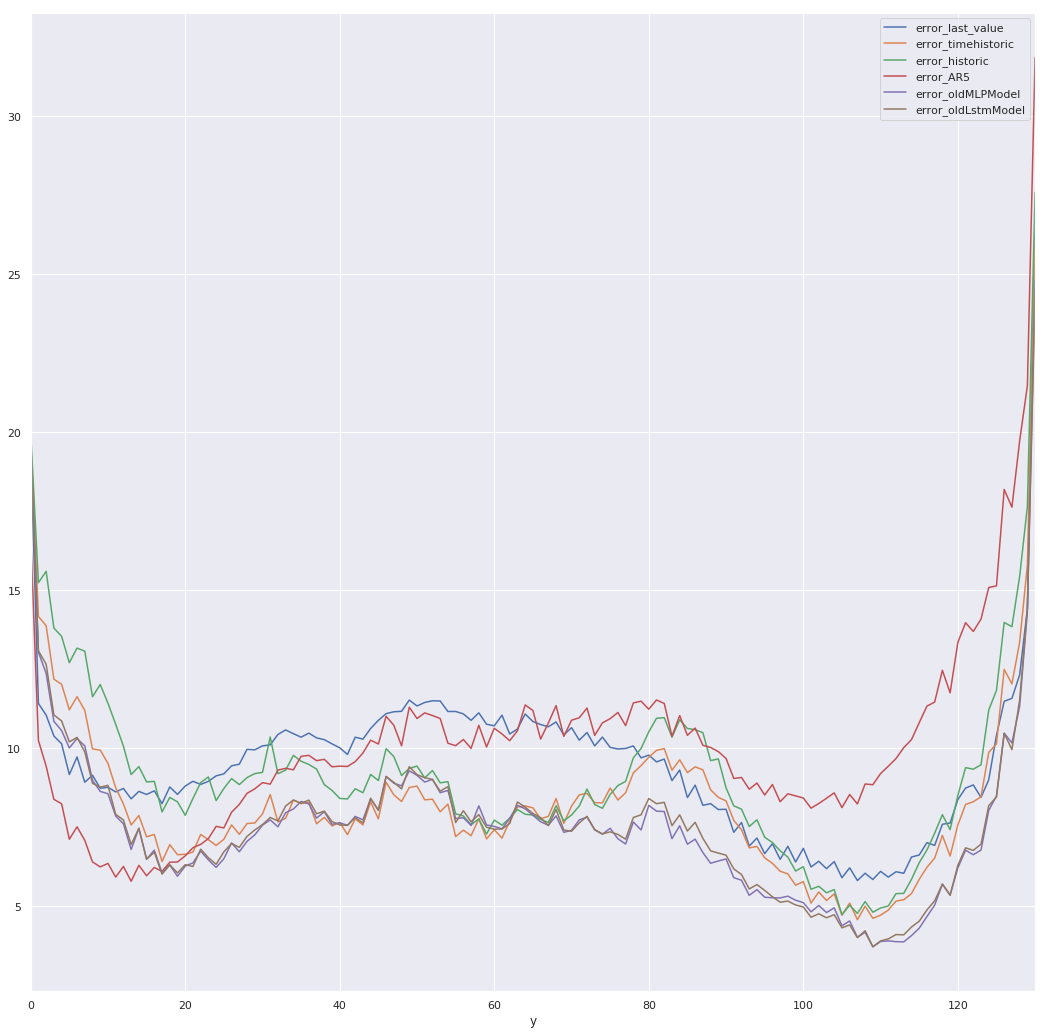

In [353]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
oldMLPModel.plotDiscreteSpeedError(ax,"oldMLPModel")
oldLstmModel.plotDiscreteSpeedError(ax,"oldLstmModel")

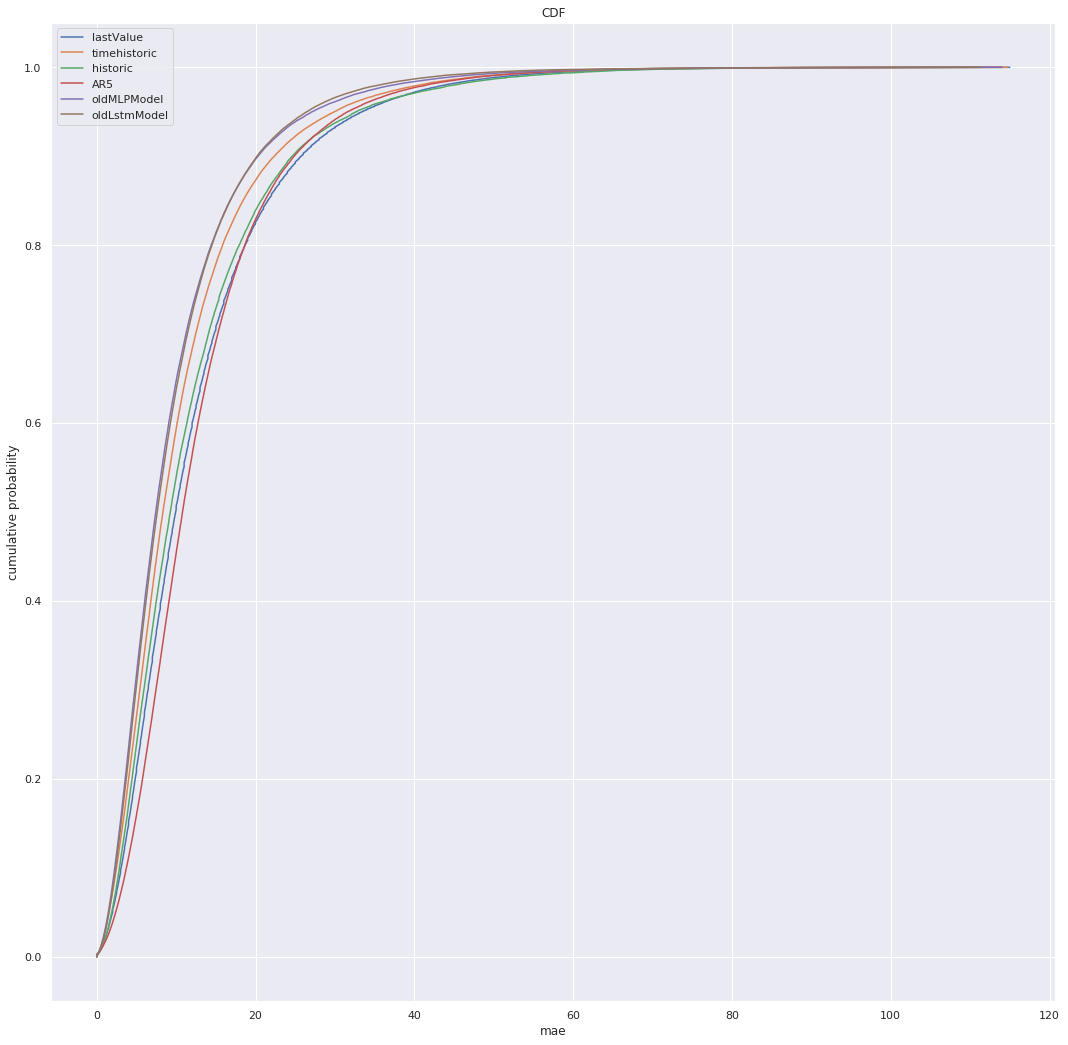

In [359]:
fig= plt.figure(figsize=(18,18))
lastValue_model_plotting.cdfPlot(error_type="mae",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mae",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mae",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mae",label="AR5",plot_lines=False)
oldMLPModel.cdfPlot(error_type="mae",label="oldMLPModel",plot_lines=False)
oldLstmModel.cdfPlot(error_type="mae",label="oldLstmModel",plot_lines=False)


In [360]:
fig.savefig("old mae.png",dpi=300,bbox_inches='tight')

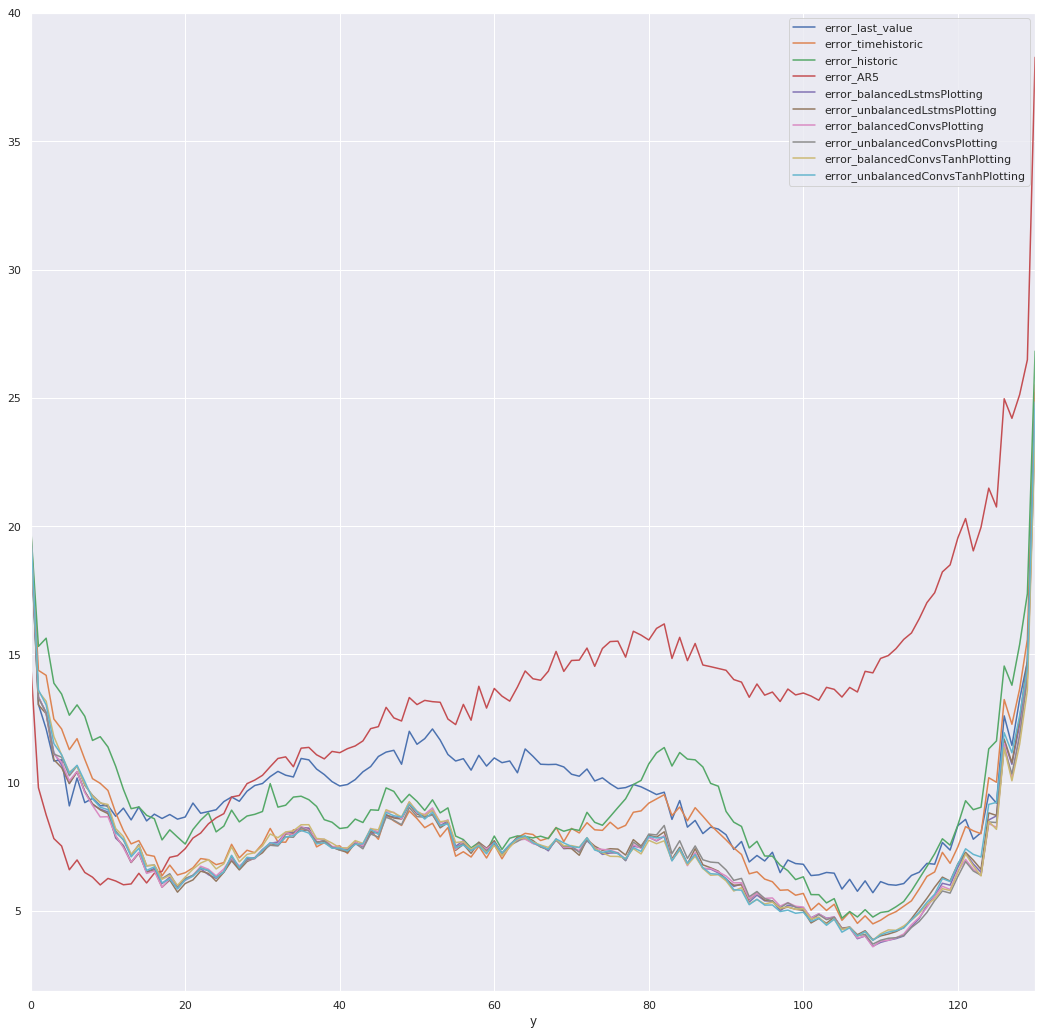

In [292]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")
historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR5")
balancedLstmsPlotting.plotDiscreteSpeedError(ax,"balancedLstmsPlotting")
unbalancedLstmsPlotting.plotDiscreteSpeedError(ax,"unbalancedLstmsPlotting")
balancedConvsPlotting.plotDiscreteSpeedError(ax,"balancedConvsPlotting")
unbalancedConvsPlotting.plotDiscreteSpeedError(ax,"unbalancedConvsPlotting")
balancedConvsTanhPlotting.plotDiscreteSpeedError(ax,"balancedConvsTanhPlotting")
unbalancedConvsTanhPlotting.plotDiscreteSpeedError(ax,"unbalancedConvsTanhPlotting")

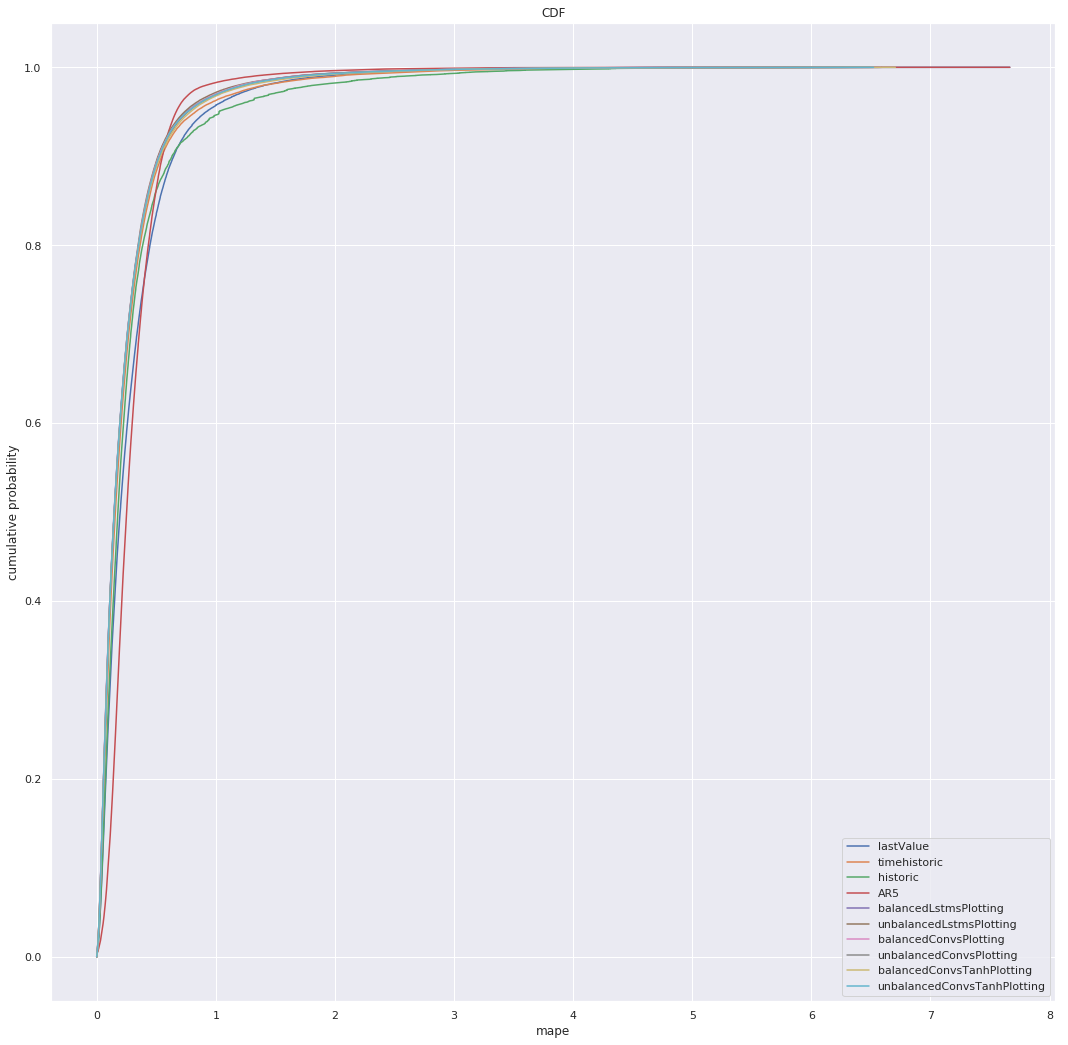

In [298]:
fig= plt.figure(figsize=(18,18))
lastValue_model_plotting.cdfPlot(error_type="mape",label="lastValue",plot_lines=False)
timehistoric_model_plotting.cdfPlot(error_type="mape",label="timehistoric",plot_lines=False)
historic_model_plotting.cdfPlot(error_type="mape",label="historic",plot_lines=False)
AR5_model_plotting.cdfPlot(error_type="mape",label="AR5",plot_lines=False)
balancedLstmsPlotting.cdfPlot(error_type="mape",label="balancedLstmsPlotting",plot_lines=False)
unbalancedLstmsPlotting.cdfPlot(error_type="mape",label="unbalancedLstmsPlotting",plot_lines=False)
balancedConvsPlotting.cdfPlot(error_type="mape",label="balancedConvsPlotting",plot_lines=False)
unbalancedConvsPlotting.cdfPlot(error_type="mape",label="unbalancedConvsPlotting",plot_lines=False)
balancedConvsTanhPlotting.cdfPlot(error_type="mape",label="balancedConvsTanhPlotting",plot_lines=False)
unbalancedConvsTanhPlotting.cdfPlot(error_type="mape",label="unbalancedConvsTanhPlotting",plot_lines=False)


In [302]:
plotmodels = [lastValue_model_plotting,
timehistoric_model_plotting,
historic_model_plotting,
AR5_model_plotting,
balancedLstmsPlotting,
unbalancedLstmsPlotting,
balancedConvsPlotting,
unbalancedConvsPlotting,
balancedConvsTanhPlotting,
unbalancedConvsTanhPlotting]

In [306]:
plotmodelsnames = ["lastValue",
"timehistoric",
"historic_model",
"AR5_model",
"balancedLstms",
"unbalancedLstms",
"balancedConvs",
"unbalancedConvs",
"balancedConvsTanh",
"unbalancedConvsTanh"]

In [361]:
oldmodels = [lastValue_model_plotting,
timehistoric_model_plotting,
historic_model_plotting,
AR5_model_plotting,
oldMLPModel,
oldLstmModel]

In [362]:
oldplotmodelsnames = ["lastValue",
"timehistoric",
"historic_model",
"AR5_model",
"oldMLPModel",
"oldLstmModel"]

In [308]:
def fastmse(x,y):
    return np.mean((x-y)**2)
def fastmae(x,y):
    return np.mean(abs(x-y))

def fastmseclip(x,y):
    return np.mean((x.clip(15)-y.clip(15))**2)
def fastmaeclip(x,y):
    return np.mean(abs(x.clip(15)-y.clip(15)))

def fastmape(x,y):
    return np.mean(abs(x.clip(15)-y.clip(15))/y.clip(15))

In [310]:
mderrorsDF = pd.DataFrame([[fastmse(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmae(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmseclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmaeclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
              [fastmape(mopl.y.flatten(),mopl.preds.flatten()) for mopl in plotmodels],
             ],
             index=["mse","mae","mse clipped 15","mae clipped 15","mape clipped 15"],
             columns=plotmodelsnames)

In [363]:
oldmderrorsDF = pd.DataFrame([[fastmse(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmae(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmseclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmaeclip(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
              [fastmape(mopl.y.flatten(),mopl.preds.flatten()) for mopl in oldmodels],
             ],
             index=["mse","mae","mse clipped 15","mae clipped 15","mape clipped 15"],
             columns=oldplotmodelsnames)

In [367]:
mderrorsDF

lastValue  timehistoric  historic_model   AR5_model  \
mse              170.966158    125.792684      154.198234  259.513076   
mae                9.056511      7.488598        8.418172   12.492965   
mse clipped 15   153.021107    115.444291      142.931156  242.956597   
mae clipped 15     8.372592      7.005848        7.928984   11.740412   
mape clipped 15    0.190567      0.150936        0.163642    0.284323   

                 balancedLstms  unbalancedLstms  balancedConvs  \
mse                 106.232870       106.004554     106.596316   
mae                   6.904965         6.917705       6.920774   
mse clipped 15       96.401422        96.208488      96.884404   
mae clipped 15        6.419529         6.432246       6.438970   
mape clipped 15       0.140700         0.141426       0.140838   

                 unbalancedConvs  balancedConvsTanh  unbalancedConvsTanh  
mse                   107.511904         108.890417           107.229664  
mae                     6.946412           6.978004             6.922060  
mse clipped 15         97.533374          98.969404            97.270537  
mae clipped 15          6.463635           6.496082             6.437642  
mape clipped 15         0.140528           0.139690             0.140294

In [368]:
oldmderrorsDF

lastValue  timehistoric  historic_model   AR5_model  \
mse              171.783094    130.368080      157.461870  164.763807   
mae                9.066898      7.645517        8.476700    9.393122   
mse clipped 15   153.648691    119.878712      145.875606  152.950033   
mae clipped 15     8.358320      7.151668        7.976548    8.788914   
mape clipped 15    0.193744      0.154589        0.163960    0.209354   

                 oldMLPModel  oldLstmModel  
mse               110.691191    107.851197  
mae                 6.964830      7.031223  
mse clipped 15    100.749765     97.841252  
mae clipped 15      6.474662      6.530444  
mape clipped 15     0.142001      0.142369

In [278]:
segments = OsmProcessing.getSegments(osmWays)

In [279]:
segments = OsmProcessing.setOneWay(segments)

In [77]:
fmap = Plotting.getFoliumMap()

In [78]:
lst =list(map(lambda x :int(x[:-2]),data_cleaner.mergedIndex[data_cleaner.mergedIndex.isin(speedDF.index)].index))

In [79]:
layer = Plotting.plotRoads(segments[segments.index.isin(lst)],fmap=fmap)

(1555,) (1555,) 1555


In [80]:
layer.add_to(fmap)

In [81]:
fmap.save("primary_map.html")

In [32]:
onedaydata = coyoteData.find({"time":{"$gte":1547560800,"$lt":1547578800}})

onedaydata = list(onedaydata)

onedayDF=pd.DataFrame(onedaydata)
onedayDF.sort_values("time", inplace=True)

In [292]:
onedayDF=onedayDF.assign(h=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x: x.hour))
onedayDF=onedayDF.assign(m=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x:  x.minute//15*15))
onedayDF=onedayDF.assign(m1=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x:  x.minute//1*1))
onedayDF=onedayDF.assign(m3=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x:  x.minute//3*3))
onedayDF=onedayDF.assign(m5=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x:  x.minute//5*5))
onedayDF=onedayDF.assign(m10=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x:  x.minute//10*10))
onedayDF=onedayDF.assign(m15=pd.to_datetime( onedayDF.time,unit = "s").apply(lambda x:  x.minute//15*15))

maxT=onedayDF.time.max()
minT=onedayDF.time.min()
colors=[matplotlib.colors.rgb2hex(x) for x in plt.cm.hot((onedayDF.time-minT)/(maxT-minT))]
onedayDF=onedayDF.assign(color = colors)

In [ ]:
onedayDF.groupby()

In [406]:
pd.MultiIndex([(x,y) for x,y in zip(range())])

MultiIndex(levels=[[14, 15, 16, 17, 18], [0, 15, 30, 45]],
           codes=[[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4], [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]],
           names=['h', 'm15'])

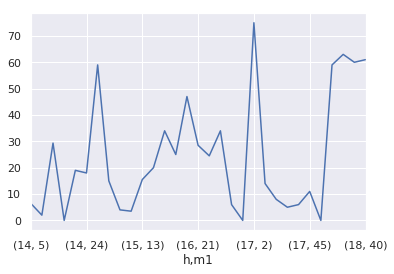

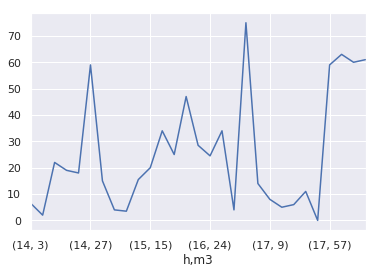

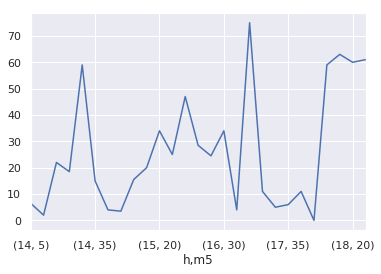

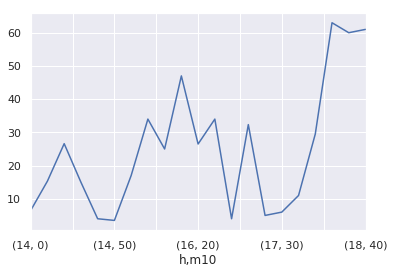

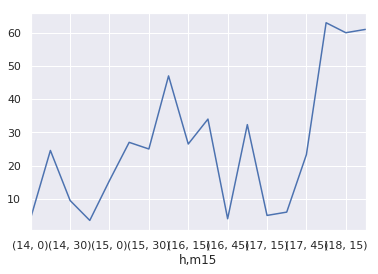

In [407]:
segID = 372736550
onedayDF[onedayDF.matching_road==segID].groupby(["h","m1"])["speed"].mean().plot()
plt.figure()
onedayDF[onedayDF.matching_road==segID].groupby(["h","m3"])["speed"].mean().plot()
plt.figure()

onedayDF[onedayDF.matching_road==segID].groupby(["h","m5"])["speed"].mean().plot()
plt.figure()

onedayDF[onedayDF.matching_road==segID].groupby(["h","m10"])["speed"].mean().plot()

plt.figure()

onedayDF[onedayDF.matching_road==segID].groupby(["h","m15"])["speed"].mean().plot()


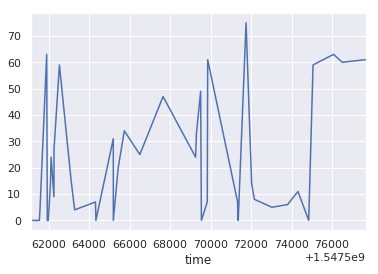

In [408]:
onedayDF[onedayDF.matching_road==segID].groupby(["time"])["speed"].mean().plot()

In [302]:
timelocs=onedayDF[onedayDF.matching_road==23162202].groupby(["h","m"])['loc'].agg(lambda x : tuple(x.apply(lambda x : x['coordinates'])))
timeIds =onedayDF[onedayDF.matching_road==23162202].groupby(["h","m"])['id'].agg(lambda x :tuple(x.unique()))

In [285]:
layers=[]
fmap = Plotting.getFoliumMap()

for time_idx in zip( timelocs.index[1:-1],timelocs.index[2:],timelocs.index[:-2]):
    current_locs = timelocs.loc[time_idx[0]]
    current_ids = timeIds.loc[time_idx[0]]
    full_locs = onedayDF[onedayDF.id.isin(current_ids)].groupby(["h","m"])['loc'].agg(lambda x : tuple(x.apply(lambda x : x['coordinates'])))
    if time_idx[1]  not  in full_locs.index or time_idx[2]  not  in full_locs.index:
        continue
    
    current_full_locs = full_locs.loc[time_idx[0]]                 
    current_colors = ["red" for _ in range(len(current_locs))]
    current_full_colors = ["green" for _ in range(len(current_full_locs))]
    
    next_locs = full_locs.loc[time_idx[1]]
    next_colors = ["blue" for _ in range(len(next_locs))]
    
    previous_locs = full_locs.loc[time_idx[2]]
    previous_colors = ["purple" for _ in range(len(previous_locs))]
           
    locs = np.concatenate((current_full_locs,current_locs ,next_locs,previous_locs))
    
    colors = np.concatenate(( current_full_colors,current_colors,next_colors,previous_colors))
    layer= Plotting.getLayerWithPositions(locs,colors,fmap,fill_colors=colors,name="N: "+str(len(current_ids))+str(time_idx),radius=2)

    layers.append(layer)
    
fmap=Plotting.stackHistotyLayers(layers,fmap)

In [303]:
layers=[]
fmap = Plotting.getFoliumMap()

current_locs = []
current_full_locs=[]
next_locs = []
current_colors = []
current_full_colors = []
next_colors = []

previous_locs =[]
previous_colors =[]

def getLocsAndColors(time_idx,full_locs,color="red"):
    locs = full_locs.loc[time_idx]
    colors = [color]*len(locs)
    return locs,colors

for time_idx in zip( timelocs.index[1:-1],timelocs.index[2:],timelocs.index[:-2]):
    current_locs += timelocs.loc[time_idx[0]]
    current_colors += ["red" for _ in range(len(current_locs))]

    current_ids = timeIds.loc[time_idx[0]]
    full_locs = onedayDF[onedayDF.id.isin(current_ids)].groupby(["h","m"])['loc'].agg(lambda x : tuple(x.apply(lambda x : x['coordinates'])))
    if time_idx[1]  not  in full_locs.index or time_idx[2]  not  in full_locs.index:
        continue
        
    current_full_locs += full_locs.loc[time_idx[0]]           
    current_full_colors += ["green" for _ in range(len(current_full_locs))]
    
    next_locs += full_locs.loc[time_idx[1]]
    next_colors += ["blue" for _ in range(len(next_locs))]

    previous_locs += full_locs.loc[time_idx[2]]
    previous_colors += ["purple" for _ in range(len(previous_locs))]
        
layer= Plotting.getLayerWithPositions(current_locs,current_colors,fmap,fill_colors=current_colors,name=" segment",radius=2)
layers.append(layer)

layer= Plotting.getLayerWithPositions(current_full_locs,current_full_colors,fmap,fill_colors=current_full_colors,name="current",radius=2)
layers.append(layer)

layer= Plotting.getLayerWithPositions(next_locs,next_colors,fmap,fill_colors=next_colors,name="next",radius=2)
layers.append(layer)

layer= Plotting.getLayerWithPositions(previous_locs,previous_colors,fmap,fill_colors=previous_colors,name="previous",radius=2)
layers.append(layer)

fmap=Plotting.stackHistotyLayers(layers,fmap)

In [304]:
fmap.save("diffuse_map.html")

In [43]:
diffusionDF=None
dates = list(set([pd.Timestamp(x.date()).value//10**9 for x in speedDF.columns]))

for date in dates:
    onedaydata = coyoteData.find({"time":{"$gte":date+14*60*60,"$lt":date+19*60*60}})
    onedayDF=pd.DataFrame(list(onedaydata))
    onedayDF.sort_values("time", inplace=True)
    onedayDF=onedayDF.assign(segmentID = onedayDF[['matching_road','heading_road']].apply(lambda x : str(x[0])+'_'+str(x[1]),axis=1))
    onedayDF=onedayDF.assign(groupID =  mergedIndex.reindex(onedayDF.segmentID.values).values)
    onedayDF=onedayDF.dropna()
    onedayDF=onedayDF.assign(quarter=(onedayDF.time-date)//(15*60))
    quarter_group_by=onedayDF.groupby(["quarter","groupID","id"]).size()
    quartersIDS = [56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
    if diffusionDF is None :
        diffusionDF = pd.DataFrame(0,index=onedayDF.groupID.unique(),columns=onedayDF.groupID.unique())
        np.fill_diagonal(diffusionDF.values, 1)
    for quarter,futur in zip(quartersIDS[:-1],quartersIDS[1:]) :
        quarte_vals=quarter_group_by.loc[quarter]
        futur_vals=quarter_group_by.loc[futur]
        seg_idxs=quarte_vals.index.get_level_values(0).unique().values
        l=list(map(lambda x : futur_vals.loc[:,quarte_vals.loc[x].index.values].groupby("groupID").sum(),seg_idxs))
        a=pd.concat(l,axis=1,sort=False)
        a.columns = seg_idxs
        diffusionDF=diffusionDF.add(a.T,fill_value=0)

diffusionDF=diffusionDF.reindex(speedDF.index).reindex(speedDF.index,axis=1)

In [ ]:
onedaydata = coyoteData.find({"time":{"$gte":1547560800,"$lt":1547578800}})

onedaydata = list(onedaydata)

onedayDF=pd.DataFrame(onedaydata)
onedayDF.sort_values("time", inplace=True)


onedayDF=onedayDF.assign(segmentID = onedayDF[['matching_road','heading_road']].apply(lambda x : str(x[0])+'_'+str(x[1]),axis=1))

onedayDF=onedayDF.assign(groupID =  mergedIndex.reindex(onedayDF.segmentID.values).values)

onedayDF=onedayDF.dropna()



In [38]:
d=pd.Timestamp(pd.to_datetime(1547560800,unit="s").date()).value//10**9

In [39]:
onedayDF=onedayDF.assign(quarter=(onedayDF.time-d)//(15*60))

In [40]:
quarter_group_by=onedayDF.groupby(["quarter","groupID","id"]).size()

In [41]:
quartersIDS=[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]

In [42]:
quarter_56 = quarter_group_by.loc[56]

In [43]:
diffusionDF = pd.DataFrame(0, index = onedayDF.groupID.unique(), columns = onedayDF.groupID.unique())
np.fill_diagonal(diffusionDF.values, 1)
for quarter,futur in zip(quartersIDS[:-1],quartersIDS[1:]) :
    quarte_vals=quarter_group_by.loc[quarter]
    futur_vals=quarter_group_by.loc[futur]
    seg_idxs=quarte_vals.index.get_level_values(0).unique().values
    l=list(map(lambda x : futur_vals.loc[:,quarte_vals.loc[x].index.values].groupby("groupID").sum(),seg_idxs))
    a=pd.concat(l,axis=1,sort=False)
    a.columns = seg_idxs
    diffusionDF=diffusionDF.add(a.T,fill_value=0)
diffusionDF=diffusionDF.reindex(speedDF.index).reindex(speedDF.index,axis=1)

In [58]:
(diffusionDF<=10).sum().sum()/(536**2)

0.6424906716417911

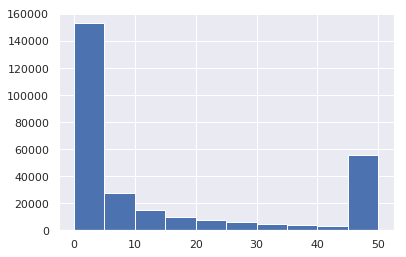

In [70]:
diffusionDF.stack().clip(upper=50).hist()

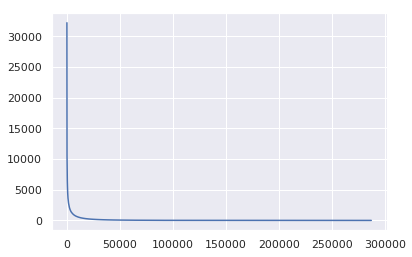

In [66]:
plt.plot(sorted(diffusionDF.stack().values,reverse=True))

In [ ]:
# plt.figure(figsize=(18,18))
plt.imshow(diffusionDF.clip(upper=10))
plt.colorbar()

In [40]:
X=x_train_00[:,-1,:]

Y=y_train_00

Y.shape,X.shape

((864, 556), (864, 556))

In [41]:
from sklearn import linear_model

In [ ]:
lassos = list(map(lambda y : sklearn.linear_model.LassoCV(fit_intercept=False,cv=5).fit(X,y), Y.T))